# CE811 Assignment 2

# Can Stacked Genetic Algorithms Following Stacked Rules Stack Cards Following Stacking Rules?

In this notebook, I shall attempt to compare the performance of a variety of genetic algorithm
chromosome types for controlling the behaviour of an agent playing *Hanabi* with 3 copies of itself,
with the aim of seeing which variety of chromosome controller is the most effective,
and the aim of seeing what

In [1]:
# But first, a word from our sponsors.
# And by that, I mean 'heres a bunch of imports have fun'
import concurrent.futures
import random
from typing import NamedTuple, Sequence, Final, Sized, Protocol, TypedDict, Generic, Literal, Set, Union, List, NoReturn, TypeVar, Tuple, Generator, FrozenSet, Callable, Iterable, Any, Dict, Iterator, Type, Optional
from enum import Enum, auto, IntFlag, Flag, EnumMeta
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes
import numpy as np
import scipy as sp
from scipy import signal
import math
import hanabi_learning_environment
from hanabi_learning_environment import rl_env
from hanabi_learning_environment.rl_env import Agent
import json
import scipy as sp
import abc
import functools
import itertools
import warnings
import pprint
from dataclasses import dataclass

from concurrent.futures import ThreadPoolExecutor





In [2]:
# And now time for another word from our other sponsors.
# By which I mean 'here are a bunch of type annotations for the sake
# of making it easier for me to use the hanabi-learning-environment'

# Yes, I know, I spelt 'Colour' as 'Color' here.
# This is mostly because the Hanabi Learning Environment
# contains the word 'color' quite a bit, and I figured that
# consistent spelling of that within the code would save
# a few headaches later on.

Color: Type = Literal["B", "G", "R", "W", "Y"]
CardColor: Type = Optional[Color]
Rank: Type = Literal[0, 1, 2, 3, 4]
CardRank: Type = Literal[-1, Rank]

ActionPD: Type = Literal["PLAY", "DISCARD"]
ActionColor: Type = Literal["REVEAL_COLOR"]
ActionRank: Type = Literal["REVEAL_RANK"]


class BaseActionDict(TypedDict):
    pass

class ActionPDDict(BaseActionDict):
    action_type: ActionPD
    card_index: int

def actplay(ind: int) -> ActionPDDict:
    """
    Helper method to create the appropriate dict for playing a card
    :param ind: index of card to play
    :return: an actionPDDict that plays that specified card
    """
    return {
        "action_type": "PLAY",
        "card_index": ind
    }

def actdiscard(ind: int) -> ActionPDDict:
    """
    Helper method for discarding
    :param ind: index of card being discarded
    :return: the appropriate actionPDDict
    """
    return {
        "action_type": "DISCARD",
        "card_index": ind
    }

class BaseActionRevealDict(BaseActionDict):
    target_offset: int

class ActionColorDict(BaseActionRevealDict):
    action_type: ActionColor
    color: Color

def actcolor(offset: int, colour: Color) -> ActionColorDict:
    """
    Helper method for revealing colour
    :param offset: player to target
    :param colour: colour to reveal
    :return: the appropriate ActionColorDict
    """
    return {
        "action_type": "REVEAL_COLOR",
        "color": colour,
        "target_offset": offset
    }

class ActionRankDict(BaseActionRevealDict):
    action_type: ActionRank
    rank: Rank

def actrank(offset: int, rank: Rank) -> ActionRankDict:
    """
    Helper method for revealing rank
    :param offset: player to target
    :param rank: rank to reveal
    :return: the appropriate ActionRankDict
    """
    return {
        "action_type": "REVEAL_RANK",
        "rank": rank,
        "target_offset": offset
    }

ActionDict = Union[ActionPDDict, ActionColorDict, ActionRankDict]
Action = Union[ActionDict, int]
ActionType = Literal[ActionPD, ActionColor, ActionRank]

class HandCard(TypedDict):
    color: CardColor
    rank: CardRank

OwnHand = List[HandCard]

class KnownCard(TypedDict):
    color: Color
    rank: Rank


KnownHand = List[KnownCard]

Card = Union[HandCard, KnownCard]

@dataclass(init=True, repr=True, eq=True, frozen=True)
class CardDataClass:
    color: Color
    rank: Rank

def knownToDataClass(c: Card) -> CardDataClass:
    return CardDataClass(c["color"], c["rank"])

TCard = TypeVar("TCard", bound=Card)

class FireworksDict(TypedDict):
    B: int
    G: int
    R: int
    W: int
    Y: int

class ObservationDict(TypedDict):
    current_player: int
    current_player_offset: int
    deck_size: int
    discard_pile: List[KnownCard]
    fireworks: FireworksDict
    information_tokens: int
    legal_moves: List[ActionDict]
    life_tokens: int
    card_knowledge: List[OwnHand]
    observed_hands: List[Union[OwnHand, KnownHand]]
    num_players: int
    vectorized: List[Literal[0, 1]]
    pyhanabi: Any


T = TypeVar("T")
def sany(it: Iterable[T]) -> Optional[T]:
    """
    Attempts to return an arbitrary item from an iterable.
    :param it: the iterable we want an arbitrary item from
    :return: the first item from that iterable, or null if it's empty
    """
    iter: Iterator[T] = it.__iter__()
    try:
        return iter.__next__()
    except StopIteration:
        return None


As mentioned earlier, the aim for this is to find out which
approach to playing Hanabi produces an optimal agent for
playing Hanabi.

And then, this optimal Hanabi agent will have to be tested based
on a set Hanabi agent evaluation environment.

The evaluation environment for the final agent involves
playing a game with 4 players, a hand size of 4,
5 suits of cards with values 0-4 (effectively 1-5 rank but
in an indexable range), and an overall deck size of 50.

Therefore, this agent shall be set up to be able to
comprehend and play this variety of Hanabi.


Here is an enum for the rules that the agent will follow,
along with a class that attempts to play hanabi,
following aforementioned rules,
given as a list of the rule enum items.




In [3]:
class Filterable(EnumMeta):
    @abc.abstractmethod
    def apply_filter(self, fl: Flag) -> bool:
        """
        Sees if this member matches anything with the given flag
        :param f: a filter to match with
        :return: true if anything matches
        """

    @abc.abstractmethod
    def apply_filter_exact(self, fl: Flag) -> bool:
        """
        Sees if this member is an EXACT match for the given flag
        :param f: a filter to match
        :return: true only if there's an EXACT match
        """


class RuleFilter(IntFlag, metaclass=Filterable):
    idc = -1
    "Used to indicate 'I don't care, allow everything'"
    nope = 0
    "A special value to indicate that nothing at all should be allowed."

    TELL = auto()
    "For rules that involve telling someone about their card, needing info tokens"
    DISCARD = auto()
    "For rules that involve discarding, requiring that we haven't reached the info token limit"

    MY_FULL_INFO = auto()
    "For rules that require this agent to know everything about itself"
    WAS_HINTED_LAST_TURN = auto()
    "For rules that require this agent to have received a hint since last turn"

    OTHER_HAS_UNKNOWN_PLAYABLE_RANK = auto()
    "For rules that require someone else to not know the rank of their playable card"
    OTHER_HAS_UNKNOWN_PLAYABLE_COLOR = auto()
    "For rules that involve someone else not knowing the colour of their playable card"
    OTHER_HAS_UNKNOWN_USELESS_RANK = auto()
    "For rules that require someone else to not know the rank of their useless card"
    OTHER_HAS_UNKNOWN_USELESS_COLOR = auto()
    "For rules that involve someone else not knowing the colour of their useless card"
    OTHER_HAS_UNKNOWN_ENDANGERED_RANK = auto()
    "For rules that require someone else to not know the rank of their endangered card"
    OTHER_HAS_UNKNOWN_ENDANGERED_COLOR = auto()
    "For rules that involve someone else not knowing the colour of their endangered card"

    OTHER_HAS_UNKNOWN_PLAYABLE = OTHER_HAS_UNKNOWN_PLAYABLE_RANK | OTHER_HAS_UNKNOWN_PLAYABLE_COLOR
    "Composite of unknown playable rank and unknown playable colour"
    OTHER_HAS_UNKNOWN_USELESS = OTHER_HAS_UNKNOWN_USELESS_RANK | OTHER_HAS_UNKNOWN_USELESS_COLOR
    "Composite of unknown useless rank and unknown useless colour"
    OTHER_HAS_UNKNOWN_ENDANGERED = OTHER_HAS_UNKNOWN_ENDANGERED_COLOR | OTHER_HAS_UNKNOWN_ENDANGERED_RANK
    "Composite of unknown endangered rank and unknown endangered colour"

    def apply_filter(self, fl: Flag) -> bool:
        return bool(self & fl)

    def apply_filter_exact(self, fl: Flag) -> bool:
        return self == fl


class RulesEnum(Flag, metaclass=Filterable):
    def __new__(
            cls,
            arity: int,
            filter: Optional[RuleFilter] = None
    ) -> "RulesEnum":
        """
        Attempts to create the individual members of this enum.
        :param arity: How many trainable arguments does this rule have?
        :param filter: Are there any special conditions that need
        to be met for this rule to be applied? If None or idc, it's always applicable.
        """
        val: int = len(cls.__members__)
        r: "RulesEnum" = object.__new__(cls)
        r._value_ = val
        r._arity = arity
        if filter is None:
            # if no filter is given, we mark it with 'idc' for 'lets not filter this'
            r._filter = RuleFilter.idc
        else:
            r._filter = filter
        return r

    PLAY_HIGHEST_KNOWN_PLAYABLE = (0, RuleFilter.MY_FULL_INFO)
    "Play the highest card which is known to be playable"
    PLAY_LOWEST_KNOWN_PLAYABLE = (0, RuleFilter.MY_FULL_INFO)
    "Play the lowest card which is known to be playable"
    PLAY_MOST_PLAYABLE_THRESH_9998 = 0
    "Play most playable card as long as it's 99.98% playable"
    PLAY_MOST_PLAYABLE_THRESH_80 = 0
    "Play most playable card as long as it's 80% playable"
    PLAY_MOST_PLAYABLE_THRESH_60 = 0
    "Play most playable card as long as it's 60% playable"
    PLAY_MOST_PLAYABLE_THRESH_A = 1
    "Plays most playable card, as long as its playability is above a TRAINABLE threshold"
    PLAY_MOST_PLAYABLE_THRESH_B = 1
    "Plays most playable card, as long as its playability is above a(nother) TRAINABLE threshold"
    PLAY_MOST_PLAYABLE_DECK_EMPTY = 0
    "Plays most playable card anyway when the deck is empty"
    PLAY_OLDEST = 0
    "Plays oldest card"
    PLAY_MOST_PLAYABLE = 0
    "Plays most playable card"

    PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_80 = (0, RuleFilter.WAS_HINTED_LAST_TURN)
    """Plays the oldest card, which we are least 80% sure is playable,
    that received a hint since our last turn."""
    PLAY_OLDEST_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_80 = (0, RuleFilter.WAS_HINTED_LAST_TURN)
    """Plays the oldest card, which are are at least 80% sure is playable,
    that we previously knew nothing about last turn."""

    PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_T = (1, RuleFilter.WAS_HINTED_LAST_TURN)
    """Plays the oldest card, based on a playability threshold of T,
    that received a hint since our last turn."""
    PLAY_OLDEST_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_T = (1, RuleFilter.WAS_HINTED_LAST_TURN)
    """Plays the oldest card, based on a playability threshold of T,
    that we previously knew nothing about last turn."""



    TELL_ANY_ABOUT_ONES = (0, RuleFilter.TELL)
    """Attempts to tell the next player who has ones that they aren't aware of about the ones they have"""
    TELL_ANY_ABOUT_KNOWN_ONES_COLOR = (0, RuleFilter.TELL)
    """Attempts to tell the next player who has ones that they know of,
    but don't know the colour, of what colour those ones are"""
    TELL_ANY_ABOUT_FIVES = (0, RuleFilter.TELL)
    """Attempts to tell the next player who has fives that they don't know are fives about them
    being fives"""
    TELL_ANY_ABOUT_KNOWN_FIVES_COLOR = (0, RuleFilter.TELL)
    """Tells the next player, who knows they have fives but not what colour those fives are,
    about what colour those fives are."""

    TELL_ANY_PLAYABLE_CARD_RANK = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_RANK)
    """Tells the next player who has a playable card,
    that they don't know the rank of, what the rank of that card is"""
    TELL_ANY_PLAYABLE_CARD_COLOR = (0, RuleFilter.TELL| RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_COLOR)
    """Tells the next player who has a playable card,
    that they don't know the colour of, what the colour of that card is"""
    TELL_ANY_PLAYABLE_CARD_HALF_INFO = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE)
    """Tells the next player who has a playable card that they know half the info about
    the remainder of the info about that card"""
    TELL_ANY_PLAYABLE_CARD_FULL_R = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE)
    """If player has a playable card they know nothing about,
    it will attempt to tell them the rank of it.
    If rank is known for all playables, they are told the colour."""
    TELL_ANY_PLAYABLE_CARD_FULL_C = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE)
    """If player has a playable card they know nothing about,
    it will attempt to tell them the colour of it.
    If colour is known for all playables, they are told the rank."""
    TELL_NEXT_PLAYABLE_CARD_HALF_INFO = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE)
    """Attempts to tell ONLY the next player the remaining unknown info about their card"""


    TELL_HIGHEST_PLAYABLE_CARD_RANK = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_RANK)
    """
    Tell the player who has the playable card of the highest rank what the rank of that card is
    If this is already known, skip this rule."""
    TELL_HIGHEST_PLAYABLE_CARD_COLOR = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_COLOR)
    """
    Tell the player who has the playable card of the highest rank what the colour of that card is
    If this is already known, skip this rule."""
    TELL_LOWEST_PLAYABLE_CARD_RANK = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_RANK)
    """
    Tell the player who has the playable card of the lowest rank what the rank of that card is.
    If this is already known, skip this rule."""
    TELL_LOWEST_PLAYABLE_CARD_COLOR = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_COLOR)
    """
    Tell the player who has the playable card of the lowest rank what the colour of that card is.
    If this is already known, skip this rule."""

    TELL_ANY_USELESS_CARD_ANY = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_USELESS)
    """Tells next player with a useless card, that they don't know stuff about,
    an arbitrary fact they don't already know about it (rank or colour)"""
    TELL_ANY_USELESS_CARD_COLOR = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_USELESS_COLOR)
    "Tells next player with a useless card that they don't know the colour of about its colour"
    TELL_ANY_USELESS_CARD_RANK = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_USELESS_RANK)
    "Tells next player with a useless card that they don't know the rank of about it being useless"
    TELL_ANY_USELESS_CARD_BELOW_MIN_PLAYED_RANK = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_USELESS_RANK)
    """Tells next player with a useless card that has a rank below the current rank for
    every colour what the rank of that useless card is."""
    TELL_ANY_USELESS_CARD_HALF_INFO = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_USELESS)
    """Tells next player, who knows half of the info about their useless card,
    the other half of the info about their useless card"""

    TELL_ANY_ENDANGERED_CARD_HALF_INFO = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED)
    """Tells next player who has an endangered card that they know half of the info about
    the rest of the info about that card"""
    TELL_ANY_ENDANGERED_CARD_RANK = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_RANK)
    """Tells next player the rank of their endangered card that they don't know the rank of"""
    TELL_ANY_ENDANGERED_CARD_COLOR = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_COLOR)
    """Tells next player the colour of their endangered card that they don't know the colour of"""
    TELL_ANY_ENDANGERED_CARD_ANY = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED)
    """Tells next player an abitrary fact about their endangered card"""

    TELL_NEXT_MOST_COMMON_RANK = (0, RuleFilter.TELL)
    """Attempts to tell the next player about their most common unknown rank
    (don't do anything if no most common unknown rank is present)"""
    TELL_NEXT_MOST_COMMON_COLOR = (0, RuleFilter.TELL)
    """Attempts to tell next player about their most common unknown colour
    (Don't do anything if there's no most common unknown colour)"""

    TELL_NEXT_OLDEST_CARD_R = (0, RuleFilter.TELL)
    """Attempts to tell next player about their oldest unknown card's rank.
    If rank is known, attempts to tell about colour."""
    TELL_NEXT_OLDEST_CARD_C = (0, RuleFilter.TELL)
    """Attempts to tell next player about their oldest unknown card.
    If colour is known, attempts to tell about rank"""

    DISCARD_KNOWN_USELESS_CARD = (0, RuleFilter.DISCARD | RuleFilter.MY_FULL_INFO)
    """Discard a card that we know is useless"""
    DISCARD_KNOWN_REDUNDANT_CARD = (0, RuleFilter.DISCARD | RuleFilter.MY_FULL_INFO)
    """Discard a card that isn't strictly needed in order to win"""

    DISCARD_MOST_DISPOSABLE_CARD_9998 = (0, RuleFilter.DISCARD)
    """Discard a card that we're 99.98% sure is useless or redundant"""
    DISCARD_MOST_DISPOSABLE_CARD_95 = (0, RuleFilter.DISCARD)
    "Discard a card that we're 95% sure is useless or redundant"
    DISCARD_MOST_DISPOSABLE_CARD_90 = (0, RuleFilter.DISCARD)
    "Discard a card that we're 90% sure is useless or redundant"
    DISCARD_MOST_DISPOSABLE_CARD_80 = (0, RuleFilter.DISCARD)
    "Discard a card that we're 80% sure is useless or redundant"
    DISCARD_MOST_DISPOSABLE_CARD_THRESH_A = (1, RuleFilter.DISCARD)
    """Uses a TRAINABLE threshold to dictate how useless/redundant
    a card needs to be to be considered discardable by this rule"""
    DISCARD_MOST_DISPOSABLE_CARD_THRESH_B = (1, RuleFilter.DISCARD)
    "ditto, but uses a different threshold"

    DISCARD_OLDEST_CARD = (0, RuleFilter.DISCARD)
    "Discards the oldest card (lowest index)"
    DISCARD_OLDEST_UNKNOWN_CARD = (0, RuleFilter.DISCARD)
    "Discards the oldest card (lowest index) we know nothing about."
    DISCARD_LAST_HINTED_CARD_80 = (0, RuleFilter.DISCARD | RuleFilter.WAS_HINTED_LAST_TURN)
    """Discard the least playable card, with a disposability of at least 80%,
    that we recieved a hint about last turn"""
    DISCARD_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_80 = (0, RuleFilter.DISCARD | RuleFilter.WAS_HINTED_LAST_TURN)
    """Discard the least playable card, with a disposability of at least 80%,
    that we previously didn't know anything about last turn."""
    DISCARD_LAST_HINTED_CARD_T = (1, RuleFilter.DISCARD | RuleFilter.WAS_HINTED_LAST_TURN)
    """Discard the least playable card, with a disposability from a trainable threshold
    that we recieved a hint about last turn"""
    DISCARD_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_T = (1, RuleFilter.DISCARD | RuleFilter.WAS_HINTED_LAST_TURN)
    """Discard the least playable card, with a disposability from a trainable threshold
    that we previously didn't know anything about last turn."""


    @property
    def arity(self) -> int:
        "How many arguments does this rule have?"
        return self._arity

    @property
    def filter(self) -> RuleFilter:
        "Find the filter conditions for this rule."
        return self._filter

    def apply_filter(self, fl: Flag) -> bool:
        """
        Sees if this rule passes the given filter. This is here so I can avoid wasting time
        on rules that don't pass the given filter
        :param fl: the filter to apply to this _filter
        :return: result of fl & self._filter
        """
        return bool(fl & self._filter)

    def apply_filter_exact(self, fl: Flag) -> bool:
        """
        Apply the given filter EXACTLY.
        :param fl: the filter to match EXACTLY with self._filter
        :return: true if this rule's filterer IS the given filter
        """
        return self._filter == fl

    @classmethod
    def filtered(
            cls,
            members: Optional[List["RulesEnum"]] = None,
            filter_by: Optional[RuleFilter] = None
    ) -> Tuple["RulesEnum",...]:
        """
        Attempts to filter a list of RulesEnum members, only returning a tuple of those members who
        satisfy the given condition
        :param members: the list of RulesEnum members to filter. If None,
        will obtain a view of all of the RulesEnums, and will filter based on that..
        :param filter_by: the condition that must be satisfied for the filtering.
        If not given, or if RuleFilter.idc is given, no filtering will happen.
        :return: A copy of the given list, filtered according to the given filter.
        """
        if members is None:
            members = [*RulesEnum.__members__.values()]
        if (filter_by is None) or (filter_by == RuleFilter.idc):
            return tuple(members)
        return tuple(m for m in members if m.apply_filter(filter_by))


st: str = "q   "
for f in RuleFilter.__members__.values():
    st = f"{st} {f:{3}}"
print(st)
print("")

for r in RulesEnum.__members__.values():
    print(str(r))
    st: str = f"{str(r.apply_filter_exact(RuleFilter.idc))[:1]}   "
    for f in RuleFilter.__members__.values():
        st = f"{st} {str(r.apply_filter(f))[:1]:{3}}"
    print(st)


q     -1   0   1   2   4   8  16  32  64 128 256 512  48 192 768

RulesEnum.PLAY_HIGHEST_KNOWN_PLAYABLE
F    T   F   F   F   T   F   F   F   F   F   F   F   F   F   F  
RulesEnum.PLAY_LOWEST_KNOWN_PLAYABLE
F    T   F   F   F   T   F   F   F   F   F   F   F   F   F   F  
RulesEnum.PLAY_MOST_PLAYABLE_THRESH_9998
T    T   F   T   T   T   T   T   T   T   T   T   T   T   T   T  
RulesEnum.PLAY_MOST_PLAYABLE_THRESH_80
T    T   F   T   T   T   T   T   T   T   T   T   T   T   T   T  
RulesEnum.PLAY_MOST_PLAYABLE_THRESH_60
T    T   F   T   T   T   T   T   T   T   T   T   T   T   T   T  
RulesEnum.PLAY_MOST_PLAYABLE_THRESH_A
T    T   F   T   T   T   T   T   T   T   T   T   T   T   T   T  
RulesEnum.PLAY_MOST_PLAYABLE_THRESH_B
T    T   F   T   T   T   T   T   T   T   T   T   T   T   T   T  
RulesEnum.PLAY_MOST_PLAYABLE_DECK_EMPTY
T    T   F   T   T   T   T   T   T   T   T   T   T   T   T   T  
RulesEnum.PLAY_OLDEST
T    T   F   T   T   T   T   T   T   T   T   T   T   T   T   T  
RulesEnum.PLAY_MO

In [4]:


class ChromosomeInfoDict(TypedDict):
    """
    A dictionary of information which will be given to each chromosome when
    they're being asked to provide info to the agent. This may or may not be
    used when a chromosome decides which list of rules to give to the agent.
    """
    info_tokens: int
    lives: int
    fireworks: FireworksDict
    deck_left: int
    player_index: int



class I_AgentChromosome(abc.ABC):

    @abc.abstractmethod
    def get_rules_and_parameters(self, info: ChromosomeInfoDict) -> Tuple[
        List[RulesEnum],
        Dict[
            RulesEnum, Tuple[int,...]
        ]
    ]:
        """
        Given a ChromosomeInfoDict, return the appropriate ordered list of rules,
        along with a dictionary holding the relevant trained parameters for
        the rules that have trained parameters.
        :param info: The info to give to the chromosome, for purposes of choosing
        what ruleset to return
        :return: the appropriate ruleset.
        """
        pass




class OtherPlayerInfo(TypedDict):
    """
    A dict holding some info about the other players.
    p: the offset for this player.
    hand: The cards the player has in their hand.
    playable: indices of playable cards in their hand
    useless: indices of unplayable cards in their hand
    endangered: indices of 'endangered' cards
      (last non-discarded instance of that card)
    ranks: indices of cards with unknown ranks
    cols: indices of cards with unknown colours
    filter: a filter that can be used later on to skip looking at non-relevant players.
    """
    p: int
    hand: List[KnownCard]
    playable: FrozenSet[int]
    useless: FrozenSet[int]
    endangered: FrozenSet[int]
    ranks: FrozenSet[int]
    cols: FrozenSet[int]
    filter: RuleFilter

class FilteredOtherPlayers(Iterator[OtherPlayerInfo]):
    """
    An iterator that attempts to iterate through the other players,
    but only returning the players who have a filter which matches
    the given filter_rule
    """
    def __init__(self, others: Iterable[OtherPlayerInfo], filter: Union[RuleFilter, RulesEnum]):
        """
        Initializes this filterer
        :param others: the info about the other players
        :param filter: the condition we're using for the filter
        """
        self._it: Iterator[OtherPlayerInfo] = others.__iter__()
        self._filter: Union[RuleFilter, RulesEnum] = filter

    def change_filter(self, new_filter: Union[RuleFilter, RulesEnum]) -> NoReturn:
        "Replaces the filter with the newly given filter"
        self._filter = new_filter

    def __next__(self) -> OtherPlayerInfo:
        n: OtherPlayerInfo = self._it.__next__()
        while not self._filter.apply_filter(n["filter"]):
            n = self._it.__next__()
        return n


"""
I'm calling this 'MyAgent' because that'll save me from having to rename this agent when I'm submitting it.
"""


class MyAgent(Agent):
    """


    I'm calling this 'MyAgent' because that'll save me from having to rename this
    class when I'm submitting it.
    """

    colors: Tuple[Color] = ('Y', 'B', 'W', 'R', 'G')
    """
    A tuple containing the possible colours for cards.
    """
    ranks: Tuple[Rank] = (0, 1, 2, 3, 4)
    """
    A tuple containing all the possible ranks for cards
    """

    individual_hanabi_cards: Tuple[KnownCard] = tuple(
        {"color": c, "rank": r}
        for c in colors
        for r in [0, 1, 2, 3, 4]
    )
    """
    A tuple holding all the possible hanabi cards
    """

    full_hanabi_deck: Tuple[KnownCard] = tuple(
        {"color": c, "rank": r}
        for c in colors
        for r in [0, 0, 0, 1, 1, 2, 2, 3, 3, 4]
    )
    """
    A tuple holding a full hanabi deck
    """

    @staticmethod
    def card_counts() -> Dict[Color, Dict[Rank, int]]:
        """
        Prepares a dictionary holding the counts of cards of each type
        in the deck. colours[ranks[counts]]
        :return: A new dictionary of dictionaries
        reflecting the initial state of the deck of cards
        """
        return dict(
            (c, dict(
                (r, 3 if r == 0 else 1 if r == 4 else 2)
                for r in MyAgent.ranks)
            ) for c in MyAgent.colors)

    def __init__(self, rules: I_AgentChromosome, config, *args, **kwargs):
        """
        Attepts to initialize this agent.
        :param rules: The I_AgentChromosome providing a view of the
        :param config: The configuration for the game that this agent is playing.
        """
        self._ruler: I_AgentChromosome = rules
        self.config = config
        # Extract max info tokens or set default to 8.
        self.max_information_tokens: int = config.get('information_tokens', 8)

        self._playernum: int = 0
        """May or may not be used for any TOTALLY SYMMETRIC not-entirely-symmetric chromosomes
        determining agent behaviours."""
        self._not_played_yet: bool = True
        """This is true if this agent has not yet had a first turn"""
        self._last_turn_cards: List[HandCard] = [
            {"color": None, "rank": -1} for _ in range(4)
        ]
        """A list holding everything we knew about our cards last turn."""

    def reset(self, config):

        self.config = config
        # Extract max info tokens or set default to 8.
        self.max_information_tokens: int = config.get('information_tokens', 8)
        self._playernum = 0
        self._not_played_yet = True
        self._last_turn_cards = [
            {"color": None, "rank": -1} for i in range(4)
        ]

    @classmethod
    def calculate_all_unseen_endangered_playable_useless_and_disposable_cards(
            cls,
            discard_pile: List[KnownCard],
            player_hands: List[List[KnownCard]],
            my_hand: List[HandCard],
            fireworks: FireworksDict
    ) -> Tuple[
        List[KnownCard],
        FrozenSet[CardDataClass],
        FrozenSet[CardDataClass],
        FrozenSet[CardDataClass],
        FrozenSet[CardDataClass]
    ]:
        """
        Returns a list of all of the cards which haven't been seen (in other words,
        all of the cards that are unknown in our hand or in the deck), along with
        a set containing all of the non-useless cards that are the last card of
        their type remaining, a set of all immediately-playable cards,
        a set of completely useless cards, and a set of the non-useless cards
        that there are at least two non-discarded instances of (meaning that one
        of those instances can be discarded without making it impossible to
        reach maximum score)
        :param discard_pile:
        :param player_hands:
        :param fireworks:
        :return:
        """
        assert len(MyAgent.full_hanabi_deck)==50 # full hanabi deck size.

        playable_card_counts: Dict[Color,Dict[Rank, int]] = cls.card_counts()

        unseen: List[KnownCard] = list(MyAgent.full_hanabi_deck)
        unplayable: Set[CardDataClass] = set()
        next_playables: Set[CardDataClass] = set()

        # subtract off all cards that have been played
        for (color, height) in fireworks.items():
            if height < 4:
                next_playables.add(CardDataClass(color, height))
            if height == 0:
                continue
            # for every card that's here, and the cards it's stacked on top of
            for rank in range(height):
                # we saw that individual card.
                card: KnownCard = {"color":color, "rank":rank}
                if card in unseen:
                    unseen.remove(card)
                unplayable.add(knownToDataClass(card))
                # and that card is unplayable.
                playable_card_counts[color][rank] = 0



        # subtract off all cards that have been discarded...
        for card in discard_pile:
            # we've seen this card, so we remove it from our list of unseen cards.
            if card in unseen:
                unseen.remove(card)
            dc: CardDataClass = knownToDataClass(card)
            if dc in unplayable:
                # if we already know that this card is unplayable, we move on.
                continue
            # Any card that's in the discard pile can't be played again
            # so we decrement the playable count appropriately.
            col: Color = card["color"]
            ran: Rank = card["rank"]
            playable_card_counts[col][ran] -= 1
            if playable_card_counts[col][ran] == 0:
                unplayable.add(dc)
                # If we've discarded all instances of this card,
                # every card higher than it in the suit is also unplayable.
                for r in range(ran + 1, 5):
                    playable_card_counts[col][r] = 0
                    unplayable.add(CardDataClass(col,r))



        # if any of the cards that are meant to be played next are no longer playable
        # they aren't considered playable.
        #for p in next_playables:
        #    if p in unplayable:
        #        next_playables.remove(p)

        # subtract off all cards that we can see in the other players' hands...
        for hand in player_hands[1:]:
            for card in hand:
                if card in unseen:
                    unseen.remove(card)
        # and our fully known cards


        last_chance_to_see: Set[CardDataClass] = set()
        disposable: Set[CardDataClass] = set()
        for c, rc in playable_card_counts.items():
            for r, n in rc.items():
                if n == 1:
                    last_chance_to_see.add(CardDataClass(c,r))
                elif n > 1:
                    disposable.add(CardDataClass(c,r))


        return (
            unseen, frozenset(last_chance_to_see),
            frozenset(next_playables), frozenset(unplayable),
            frozenset(disposable)
        )


    @classmethod
    def filter_card_list_by_hint(
            cls,
            not_impossible_cards: List[KnownCard],
            hinted: Card
    ) -> List[Card]:
        """
        Given a list of cards which are not impossible to get,
        returns only the cards which have a rank/colour matching those in the hint.
        Also, if the filtering filters out all but one rank/colour,
        indicating that this card is of that rank/colour, the card will have its rank
        updated appropriately.
        :param not_impossible_cards: list of cards that aren't impossible to get
        :param hinted: the card with the info we know about it
        :return: the list of cards that the given 'hinted' card could be.
        """

        if hinted["color"] is not None and hinted["rank"] != -1:
            return [hinted]

        filtered_card_list: List[Card] = not_impossible_cards.copy()

        # uses what we do know about the card to filter the card list
        if hinted["color"] is not None:
            tmpc: Color = hinted["color"]
            filtered_card_list = [c for c in filtered_card_list if c["color"] == tmpc]
        if hinted["rank"] and hinted["rank"] != -1:
            tmpr: Rank = hinted["rank"]
            filtered_card_list = [c for c in filtered_card_list if c["rank"] == tmpr]


        """
        # using the card list, we then attempt to eliminate the impossible
        # regarding what card the hinted card might be
        if hinted["color"] is None and filtered_card_list:
            c0col: Color = filtered_card_list[0]["color"]
            #if all(c["color"]==c0col for c in filtered_card_list):
            #    hinted["color"] = c0col
        if (not hinted["rank"] or hinted["rank"] == -1) and filtered_card_list:
            c0rank: Rank = filtered_card_list[0]["rank"]
            #if all(c["rank"] == c0rank for c in filtered_card_list):
            #    hinted["rank"] = c0rank
        """

        return filtered_card_list

    @staticmethod
    def is_card_playable(card: KnownCard, fireworks: FireworksDict) -> bool:
        """
        Checks if a card is immediately playable or not
        :param card: the card we're checking
        :param fireworks: the fireworks dict
        :return: true if the given card can be played.
        """
        return card['rank'] == fireworks[card['color']]

    @classmethod
    def filter_card_list_by_playability(
            cls,
            card_list: List[KnownCard],
            fireworks: FireworksDict
    ) -> List[KnownCard]:
        """
        Attempts to obtain only the playable cards in the given card list.
        :param card_list: list of cards to check for playability
        :param fireworks: the fireworks dictionary (current state of the game)
        :return: true if the
        """
        return [c for c in card_list if cls.is_card_playable(c,fireworks)]

    @classmethod
    def get_unplayables_from_discard_pile(cls, discard_pile: List[KnownCard]) -> FrozenSet[CardDataClass]:
        """
        Attempts to get all of the cards that are currently unplayable,
        given the state of the discard pile.
        :param discard_pile: The list of all of the cards that have been discarded
        :return: A set with all of the cards which are known to not be playable.
        This consists both of cards which are 'unplayable' because they've been discarded,
        but also those which are 'unplayable' because the card that needed to be played
        before playing this one can't be played due to all of them being discarded instead.
        """

        undiscarded_counts: Dict[Color,Dict[Rank, int]] = cls.card_counts()

        unplayables: Set[CardDataClass] = set()

        for d in discard_pile:
            dc: CardDataClass = knownToDataClass(d)
            if dc in unplayables:
                continue
            undiscarded_counts[d["color"]][d["rank"]] -= 1
            if undiscarded_counts[d["color"]][d["rank"]] <= 0:
                unplayables.add(d)
                drank: Rank = d["rank"]
                if drank < 4:
                    dcol: Color = d["color"]
                    for i in range(drank, 5):
                        undiscarded_counts[dcol][i] = 0
                        unplayables.add(dc)

        return frozenset(unplayables)

    @staticmethod
    def filter_card_list_by_unplayable(
            card_list: List[KnownCard],
            fireworks: FireworksDict,
            discard_unplayable: FrozenSet[CardDataClass]
    )-> List[KnownCard]:
        """
        finds out which cards in card list are always going to be unplayable on its colour's firework,
        due to it being a number that's already been played.
        :param card_list: the card list to filter
        :param fireworks: the current fireworks dictionary
        :param discard_unplayable: the set of cards that we know are unplayable according to the discard pile
        :return: the remaining playable cards
        """
        # noinspection PyTypedDict
        return [c for c in card_list if knownToDataClass(c) not in discard_unplayable and c["rank"] < fireworks[c["color"]]]




    def act(self, observation: ObservationDict) -> Optional[Action]:

        if observation['current_player_offset'] != 0:
            # but only the player with offset 0 is allowed to make an action.
            # The other players are just observing.

            if self._not_played_yet: # also updating the cheeky not-that-symmetric thing
                self._playernum += 1
            return None
        if self._not_played_yet:
            self._not_played_yet = False

        info: int = observation['information_tokens']
        lives: int= observation["life_tokens"]
        deck: int = observation["deck_size"]

        # attempts to filter out which rules can be skipped.
        filter_for_actions: RuleFilter = RuleFilter.nope
        if info < self.max_information_tokens:
            filter_for_actions |= RuleFilter.DISCARD
        if info > 0:
            filter_for_actions |= RuleFilter.TELL

        fireworks: FireworksDict = observation['fireworks']
        my_hand: OwnHand = observation['card_knowledge'][0]

        observation["vectorized"] = []

        hand_size=len(my_hand)

        last_turn_hinted_indices: Set[int] = set()
        last_turn_unknown_hinted_indices: Set[int] = set()

        for c in my_hand:
            if c["rank"] is None:
                c["rank"] = -1

        # we find the cards that had a hint given for them last turn
        # and carry over any deductions regarding the state of the cards
        # that we found out last turn
        for i in range(len(self._last_turn_cards)):
            if self._last_turn_cards[i]["color"] != my_hand[i]["color"]:
                if my_hand[i]["color"] is not None:
                    if self._last_turn_cards[i]["rank"] == -1:
                        last_turn_unknown_hinted_indices.add(i)
                    last_turn_hinted_indices.add(i)
            if self._last_turn_cards[i]["rank"] != my_hand[i]["rank"]:
                if my_hand[i]["rank"] != -1:
                    if self._last_turn_cards[i]["color"] is None:
                        last_turn_unknown_hinted_indices.add(i)
                    last_turn_hinted_indices.add(i)


        if last_turn_hinted_indices:
            filter_for_actions |= RuleFilter.WAS_HINTED_LAST_TURN

        discarded: List[KnownCard] = observation['discard_pile']

        # build some useful lists of information about what we hold in our hand and what team-mates know about their hands.

        unseen_endangered_playable_useless_disposable: Tuple[
            List[KnownCard], FrozenSet[CardDataClass],
            FrozenSet[CardDataClass], FrozenSet[CardDataClass],
            FrozenSet[CardDataClass]
        ] = self.calculate_all_unseen_endangered_playable_useless_and_disposable_cards(
            discarded, observation['observed_hands'], my_hand, fireworks
        )

        unseen: List[KnownCard] = unseen_endangered_playable_useless_disposable[0]
        endangered: FrozenSet[CardDataClass] = unseen_endangered_playable_useless_disposable[1]
        playable: FrozenSet[CardDataClass] = unseen_endangered_playable_useless_disposable[2]
        useless: FrozenSet[CardDataClass] = unseen_endangered_playable_useless_disposable[3]
        disposable: FrozenSet[CardDataClass] = unseen_endangered_playable_useless_disposable[4]




        possible_cards_in_hand: List[List[Card]] = [self.filter_card_list_by_hint(unseen, h) for h in my_hand]
        if any(len(l) == 0 for l in possible_cards_in_hand):
            pprint.pprint(observation)
            pprint.pprint(my_hand)
            pprint.pprint(list(len(l) == 0 for l in possible_cards_in_hand))
            pprint.pprint(possible_cards_in_hand)
            pprint.pprint(unseen)
            raise RuntimeError("OH NO!")
        p_playable_cards_in_hand: List[List[KnownCard]] =[[p for p in possible if knownToDataClass(p) in playable] for possible in possible_cards_in_hand]



        probability_cards_playable: List[float] =[len(p_playable_cards_in_hand[index])/len(possible_cards_in_hand[index]) for index in range(hand_size)]
        p_endangered_cards_in_hand: List[List[KnownCard]] = [[p for p in possible if knownToDataClass(p) in endangered] for possible in possible_cards_in_hand]
        probability_cards_endangered: List[float] = [len(p_endangered_cards_in_hand[index])/len(possible_cards_in_hand[index]) for index in range(hand_size)]
        p_useless_cards_in_hand: List[List[KnownCard]] = [[p for p in possible if knownToDataClass(p) in useless] for possible in possible_cards_in_hand]
        probability_cards_useless: List[float] =[len(p_useless_cards_in_hand[index])/len(possible_cards_in_hand[index]) for index in range(hand_size)]

        p_disposable_cards_in_hand: List[List[KnownCard]] = [[p for p in possible if knownToDataClass(p) in disposable or knownToDataClass(p) in useless] for possible in possible_cards_in_hand]
        probability_cards_disposable: List[float] = [len(p_disposable_cards_in_hand[index])/len(possible_cards_in_hand[index]) for index in range(hand_size)]

        hinted_card_ind_playability: Dict[int, float] = dict(
            (ind, probability_cards_playable[ind]) for ind in last_turn_hinted_indices
        )
        hinted_unknown_playability: Dict[int, float] = dict(
            (ind, probability_cards_playable[ind]) for ind in last_turn_unknown_hinted_indices
        )
        hinted_card_ind_disposability: Dict[int, float] = dict(
            (ind, probability_cards_disposable[ind]) for ind in last_turn_hinted_indices
        )
        hinted_unknown_disposability: Dict[int, float] = dict(
            (ind, probability_cards_disposable[ind]) for ind in last_turn_unknown_hinted_indices
        )

        most_disposable_prob_index: Tuple[float, int] = (
            np.max(probability_cards_disposable).astype(float),
            np.argmax(probability_cards_disposable).astype(int)
        )

        most_playable_prob_index: Tuple[float, int] = (
            np.max(probability_cards_playable).astype(float),
            np.argmax(probability_cards_playable).astype(int)
        )

        most_useless_card_index: Tuple[float, int] = (
            np.max(probability_cards_useless).astype(float),
            np.argmax(probability_cards_useless).astype(int)
        )


        others_info: List[OtherPlayerInfo] = []

        for i in range(1, observation['num_players']):
            other_cards: List[KnownCard] = observation['observed_hands'][i]
            other_hand: List[HandCard] = observation['card_knowledge'][i]

            o_p: Set[int] = set()
            o_u: Set[int] = set()
            o_e: Set[int] = set()
            o_r: Set[int] = set()
            o_c: Set[int] = set()
            for c in range(len(other_cards)):
                o_k: CardDataClass = knownToDataClass(other_cards[c])
                if o_k in useless:
                    o_u.add(c)
                else:
                    if o_k in playable:
                        o_p.add(c)
                    if o_k in endangered:
                        o_e.add(c)
                o_h: HandCard = other_hand[c]
                if o_h["rank"] == -1:
                    o_r.add(c)
                if o_h["color"] is None:
                    o_c.add(c)


            other_filter: RuleFilter = RuleFilter.nope
            if o_r:
                other_filter |= RuleFilter.TELL
                if o_r.union(o_p):
                    other_filter |= RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_RANK
                if o_r.union(o_e):
                    other_filter |= RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_RANK
                if o_r.union(o_u):
                    other_filter |= RuleFilter.OTHER_HAS_UNKNOWN_USELESS_RANK
            if o_c:
                other_filter |= RuleFilter.TELL
                if o_c.union(o_p):
                    other_filter |= RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_COLOR
                if o_c.union(o_e):
                    other_filter |= RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_COLOR
                if o_c.union(o_u):
                    other_filter |= RuleFilter.OTHER_HAS_UNKNOWN_USELESS_COLOR

            others_info.append({
                "p": i,
                "hand": other_cards,
                "playable": frozenset(o_p),
                "useless": frozenset(o_u),
                "endangered": frozenset(o_e),
                "ranks": frozenset(o_r),
                "cols": frozenset(o_c),
                "filter": other_filter
            })
            filter_for_actions |= other_filter



        my_unknown_card_indices:List[Card] = list(c for c in my_hand if c["rank"] == -1 or c["color"] is None)
        my_known_ranks:  List[Card] = list(c for c in my_hand if c["rank"] != -1)
        my_known_colors: List[Card] = list(c for c in my_hand if c["color"] is not None)

        my_known_cards:  List[KnownCard] = list(c for c in my_hand if c["rank"] != -1 and c["color"] is not None)
        my_known_indices:FrozenSet[int] = frozenset(c for c in range(hand_size) if my_hand[c]["rank"] != -1 and my_hand[c]["color"] is not None)
        my_known_playable_indices: FrozenSet[int] = frozenset(c for c in my_known_indices if knownToDataClass(my_hand[c]) in playable)
        my_known_useless_indices: FrozenSet[int] = frozenset(c for c in my_known_indices if knownToDataClass(my_hand[c]) in useless)
        my_known_disposable_indices: FrozenSet[int] = frozenset(c for c in my_known_indices if c in my_known_useless_indices or knownToDataClass(my_hand[c]) in disposable)
        if my_known_cards:
            filter_for_actions |= RuleFilter.MY_FULL_INFO


        c_rules_params: Tuple[
            List[RulesEnum],Dict[RulesEnum, Tuple[int,...]]
        ] =self._ruler.get_rules_and_parameters({
            "info_tokens": info,
            "lives": lives,
            "fireworks": fireworks,
            "deck_left": deck,
            "player_index": self._playernum
        })

        params: Dict[RulesEnum, Tuple[int,...]] = c_rules_params[1]
        filtered_rules: Tuple[RulesEnum] = RulesEnum.filtered(c_rules_params[0], filter_for_actions)

        chosen_action: Action = observation["legal_moves"][0]

        for r in filtered_rules:

            if r.apply_filter_exact(RuleFilter.idc):
                if r == RulesEnum.PLAY_MOST_PLAYABLE_DECK_EMPTY:
                    if deck == 0:
                        chosen_action = actplay(most_playable_prob_index[1])
                        break
                    continue
                elif r == RulesEnum.PLAY_OLDEST:
                    chosen_action = actplay(0)
                    break
                playability = most_playable_prob_index[0]

                playing_the_thing: bool = False
                if r == RulesEnum.PLAY_MOST_PLAYABLE_THRESH_9998:
                    playing_the_thing = playability >= 0.9988
                elif r == RulesEnum.PLAY_MOST_PLAYABLE_THRESH_80:
                    playing_the_thing = playability >= 0.8
                elif r == RulesEnum.PLAY_MOST_PLAYABLE_THRESH_60:
                    playing_the_thing = playability >= 0.6
                elif r == RulesEnum.PLAY_MOST_PLAYABLE_THRESH_A or r == RulesEnum.PLAY_MOST_PLAYABLE_THRESH_B:
                    playing_the_thing = playability >= params[r][0]
                elif r == RulesEnum.PLAY_MOST_PLAYABLE:
                    playing_the_thing = True
                else:
                    raise RuntimeError("UNEXPECTED END OF IF STATEMENT! \n"+
                                       f"unfilterables \nrule {r}")
                if playing_the_thing:
                    chosen_action = actplay(most_playable_prob_index[1])
                    break
                else:
                    continue

            elif r.apply_filter(RuleFilter.TELL):
                if info == 0:
                    continue
                others: FilteredOtherPlayers = FilteredOtherPlayers(others_info, r.filter)
                tell_this: Optional[Union[ActionRankDict, ActionColorDict]] = None
                if r.apply_filter_exact(RuleFilter.TELL):
                    if r == RulesEnum.TELL_ANY_ABOUT_ONES:
                        for p in others:
                            if any(True for ir in p["ranks"] if p["hand"][ir]["rank"] == 0):
                                tell_this = actrank(p["p"],0)
                                break
                    elif r == RulesEnum.TELL_ANY_ABOUT_KNOWN_ONES_COLOR:
                        for p in others:
                            ic: int = sany([ir for ir in p["cols"] - p["ranks"] if p["hand"][ir]["rank"] == 0])
                            if ic:
                                tell_this = actcolor(p["p"],p["hand"][ic]["color"])
                                break
                    elif r == RulesEnum.TELL_ANY_ABOUT_FIVES:
                        for p in others:
                            if any(True for ir in p["ranks"] if p["hand"][ir]["rank"] == 4):
                                tell_this = actrank(p["p"],4)
                                break
                    elif r == RulesEnum.TELL_ANY_ABOUT_KNOWN_FIVES_COLOR:
                        for p in others:
                            ic: int = sany([ir for ir in p["cols"] - p["ranks"] if p["hand"][ir]["rank"] == 4])
                            if ic:
                                tell_this = actcolor(p["p"],p["hand"][ic]["color"])
                                break
                    elif r == RulesEnum.TELL_NEXT_MOST_COMMON_RANK:
                        p: OtherPlayerInfo = others_info[0]
                        if p["ranks"]:
                            tell_this = actrank(p["p"],max(
                                MyAgent.ranks,
                                key=lambda ran: sum(c["rank"]==ran for c in p["hand"])
                                )
                            )
                    elif r == RulesEnum.TELL_NEXT_MOST_COMMON_COLOR:
                        p: OtherPlayerInfo = others_info[0]
                        if p["cols"]:
                            tell_this = actcolor(p["p"],max(
                                MyAgent.colors,
                                key=lambda col: sum(c["color"]==col for c in p["hand"])
                            ))
                    elif r == RulesEnum.TELL_NEXT_OLDEST_CARD_R:
                        p: OtherPlayerInfo = others_info[0]
                        comb: FrozenSet[int] = p["cols"] | p["ranks"]
                        if comb:
                            old: int = min(comb)
                            if old in p["ranks"]:
                                tell_this = actrank(
                                    p["p"],
                                    p["hand"][old]["rank"]
                                )
                            else:
                                tell_this = actcolor(
                                    p["p"],
                                    p["hand"][old]["color"]
                                )
                    elif r == RulesEnum.TELL_NEXT_OLDEST_CARD_C:
                        p: OtherPlayerInfo = others_info[0]
                        comb: FrozenSet[int] = p["cols"] | p["ranks"]
                        if comb:
                            old: int = min(comb)
                            if old in p["cols"]:
                                tell_this = actcolor(
                                    p["p"],
                                    p["hand"][old]["color"]
                                )
                            else:
                                tell_this = actrank(
                                    p["p"],
                                    p["hand"][old]["rank"]
                                )
                    else:
                        raise RuntimeError("Unexpected end of if statement!\n" +
                                           f"{RuleFilter.TELL} exact\nrule: {r}")

                elif r.apply_filter(RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE):
                    if r == RulesEnum.TELL_ANY_PLAYABLE_CARD_HALF_INFO:
                        for p in others:
                            halves: Set[int] = p["ranks"] ^ p["cols"]
                            if halves:
                                ind: int = sany(halves)
                                if ind in p["ranks"]:
                                    tell_this = actrank(p["p"],p["hand"][ind]["rank"])
                                else:
                                    tell_this = actcolor(p["p"],p["hand"][ind]["color"])
                                break
                    elif r == RulesEnum.TELL_NEXT_PLAYABLE_CARD_HALF_INFO:
                        p: OtherPlayerInfo = others_info[0]
                        if not RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE.apply_filter(p["filter"]):
                            continue
                        halves: FrozenSet[int] = (p["ranks"] ^ p["cols"]) & p["playable"]
                        if halves:
                            ind: int = sany(halves)
                            if ind in p["ranks"]:
                                tell_this = actrank(p["p"],p["hand"][ind]["rank"])
                            else:
                                tell_this = actcolor(p["p"],p["hand"][ind]["color"])
                            break
                    elif r == RulesEnum.TELL_ANY_PLAYABLE_CARD_FULL_R:
                        for p in others:
                            if p["ranks"]:
                                tell_this = actrank(p["p"],p["hand"][sany(p["ranks"])]["rank"])
                            else:
                                tell_this = actcolor(p["p"],p["hand"][sany(p["cols"])]["color"])
                            break
                    elif r == RulesEnum.TELL_ANY_PLAYABLE_CARD_FULL_C:
                        for p in others:
                            if p["cols"]:
                                tell_this = actcolor(p["p"],p["hand"][sany(p["cols"])]["color"])
                            else:
                                tell_this = actrank(p["p"],p["hand"][sany(p["ranks"])]["rank"])
                            break
                    elif r.apply_filter(RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_COLOR):
                        others.change_filter(RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_COLOR)
                        if r == RulesEnum.TELL_ANY_PLAYABLE_CARD_COLOR:
                            for p in others:
                                if p["cols"]:
                                    tell_this = actcolor(p["p"],p["hand"][sany(p["cols"])]["color"])
                                    break
                        elif r == RulesEnum.TELL_HIGHEST_PLAYABLE_CARD_COLOR:
                            for p in others:
                                if p["cols"]:
                                    tell_this = actcolor(p["p"],p["hand"][max(
                                        p["cols"],
                                        key=lambda c1: p["hand"][c1]["rank"]
                                    )]["color"])
                                    break
                        elif r == RulesEnum.TELL_LOWEST_PLAYABLE_CARD_COLOR:
                            for p in others:
                                if p["cols"]:
                                    tell_this = actcolor(p["p"],p["hand"][min(
                                        p["cols"],
                                        key=lambda c1: p["hand"][c1]["rank"]
                                    )]["color"])
                                    break
                        else:
                            raise RuntimeError(
                                "Unexpected end of if statement!\n" +
                                f"{RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_COLOR} branch\n"+
                                f"Rule {r}")
                        pass
                    elif r.apply_filter(RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_RANK):
                        others.change_filter(RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_RANK)
                        if r == RulesEnum.TELL_ANY_PLAYABLE_CARD_RANK:
                            for p in others:
                                if p["ranks"]:
                                    tell_this = actcolor(p["p"],p["hand"][sany(p["ranks"])]["rank"])
                                    break
                        elif r == RulesEnum.TELL_HIGHEST_PLAYABLE_CARD_RANK:
                            for p in others:
                                if p["ranks"]:
                                    tell_this = actrank(p["p"],p["hand"][max(
                                        p["ranks"],
                                        key=lambda c2: p["hand"][c2]["rank"]
                                    )]["rank"])
                                    break
                        elif r == RulesEnum.TELL_LOWEST_PLAYABLE_CARD_RANK:
                            for p in others:
                                if p["ranks"]:
                                    tell_this = actrank(p["p"],p["hand"][min(
                                        p["ranks"],
                                        key=lambda c2: p["hand"][c2]["rank"]
                                    )]["rank"])
                                    break
                        else:
                            raise RuntimeError(
                                "Unexpected end of if statement!\n" +
                                f"{RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_COLOR} branch\n"+
                                f"Rule {r}")
                        pass
                    else:
                        raise RuntimeError("Unexpected end of if statement!\n" +
                                           f"{RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE} branch\n"+
                                           f"Rule {r}")
                elif r.apply_filter(RuleFilter.OTHER_HAS_UNKNOWN_USELESS):
                    others.change_filter(RuleFilter.OTHER_HAS_UNKNOWN_USELESS)
                    if r == RulesEnum.TELL_ANY_USELESS_CARD_ANY:
                        for p in others:
                            kaput: FrozenSet[int] = (p["ranks"] | p["cols"]) & p["useless"]
                            if kaput:
                                tell: int = sany(kaput)
                                if tell in p["ranks"]:
                                    tell_this = actrank(p["p"],p["hand"][tell]["rank"])
                                else:
                                    tell_this = actcolor(p["p"],p["hand"][tell]["color"])
                                break
                    elif r == RulesEnum.TELL_ANY_USELESS_CARD_HALF_INFO:
                        for p in others:
                            kaput: FrozenSet[int] = (p["ranks"] ^ p["cols"]) & p["useless"]
                            if kaput:
                                tell: int = sany(kaput)
                                if tell in p["ranks"]:
                                    tell_this = actrank(p["p"],p["hand"][tell]["rank"])
                                else:
                                    tell_this = actcolor(p["p"],p["hand"][tell]["color"])
                                break
                    elif r.apply_filter(RuleFilter.OTHER_HAS_UNKNOWN_USELESS_RANK):
                        others.change_filter(RuleFilter.OTHER_HAS_UNKNOWN_USELESS_RANK)
                        if r == RulesEnum.TELL_ANY_USELESS_CARD_BELOW_MIN_PLAYED_RANK:
                            min_played: int = min(fireworks.values())
                            if min_played == -1:
                                # skip this rule if there's an empty stack
                                continue
                            for p in others:
                                r_u: FrozenSet[int] = p["ranks"] & p["useless"]
                                if r_u:
                                    min_ran: int = p["hand"][min(
                                        r_u,
                                        key=lambda u: p["hand"][u]["rank"]
                                    )]["rank"]
                                    if min_ran <= min_played:
                                        tell_this = actrank(p["p"],min_ran)
                                        break
                        elif r == RulesEnum.TELL_ANY_USELESS_CARD_RANK:
                            for p in others:
                                r_u: FrozenSet[int] = p["ranks"] & p["useless"]
                                if r_u:
                                    tell: int = sany(r_u)
                                    if tell in p["ranks"]:
                                        tell_this = actrank(p["p"],p["hand"][tell]["rank"])
                                        break
                        else:
                            raise RuntimeError("Unexpected end of if statement!\n"+
                                               f"{RuleFilter.OTHER_HAS_UNKNOWN_USELESS_RANK} branch\n"+
                                               f"Rule: {r}")

                    elif r.apply_filter(RuleFilter.OTHER_HAS_UNKNOWN_USELESS_COLOR):
                        others.change_filter(RuleFilter.OTHER_HAS_UNKNOWN_USELESS_COLOR)
                        if r == RulesEnum.TELL_ANY_USELESS_CARD_COLOR:
                            for p in others:
                                c_u: FrozenSet[int] = p["cols"] & p["useless"]
                                if c_u:
                                    tell: int = sany(c_u)
                                    if tell in p["cols"]:
                                        tell_this = actcolor(p["p"],p["hand"][tell]["color"])
                                        break
                        else:
                            raise RuntimeError("Unexpected end of if statement!\n"+
                                               f"{RuleFilter.OTHER_HAS_UNKNOWN_USELESS_COLOR} branch\n"+
                                               f"Rule: {r}")
                    else:
                        raise RuntimeError("Unexpected end of if statement!\n"+
                                               f"{RuleFilter.OTHER_HAS_UNKNOWN_USELESS} branch\n"+
                                               f"Rule: {r}")
                elif r.apply_filter(RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED):
                    others.change_filter(RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED)
                    if r == RulesEnum.TELL_ANY_ENDANGERED_CARD_HALF_INFO:
                        for p in others:
                            e_h: FrozenSet[int] = (p["cols"] ^ p["ranks"]) & p["endangered"]
                            if e_h:
                                tell: int = sany(e_h)
                                if tell in p["ranks"]:
                                    tell_this = actrank(p["p"],p["hand"][tell]["rank"])
                                else:
                                    tell_this = actcolor(p["p"],p["hand"][tell]["color"])
                                break
                    elif r == RulesEnum.TELL_ANY_ENDANGERED_CARD_ANY:
                        for p in others:
                            e_u: FrozenSet[int] = (p["cols"] | p["ranks"]) & p["endangered"]
                            if e_u:
                                tell: int = sany(e_u)
                                if tell in p["ranks"]:
                                    tell_this = actrank(p["p"],p["hand"][tell]["rank"])
                                else:
                                    tell_this = actcolor(p["p"],p["hand"][tell]["color"])
                                break
                    elif r.apply_filter(RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_COLOR):
                        others.change_filter(RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_COLOR)
                        if r == RulesEnum.TELL_ANY_ENDANGERED_CARD_COLOR:
                            for p in others:
                                e_c: FrozenSet[int] = p["cols"] & p["endangered"]
                                if e_c:
                                    tell_this = actcolor(
                                        p["p"],p["hand"][sany(e_c)]["color"]
                                    )
                                break
                        else:
                            raise RuntimeError("Unexpected end of if statement!\n"+
                                               f"{RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_COLOR} branch\n"+
                                               f"Rule: {r}")
                    elif r.apply_filter(RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_RANK):
                        others.change_filter(RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_RANK)
                        if r == RulesEnum.TELL_ANY_ENDANGERED_CARD_RANK:
                            for p in others:
                                e_r: FrozenSet[int] = p["ranks"] & p["endangered"]
                                if e_r:
                                    tell_this = actrank(
                                        p["p"],p["hand"][sany(e_r)]["rank"]
                                    )
                                break
                        else:
                            raise RuntimeError("Unexpected end of if statement!\n"+
                                               f"{RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_RANK} branch\n"+
                                               f"Rule: {r}")
                    else:
                        raise RuntimeError("Unexpected end of if statement!\n"+
                                           f"{RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED} branch\n"+
                                           f"Rule: {r}")
                else:
                    raise RuntimeError("Unexpected end of if statement!\n"+
                                       f"{RuleFilter.TELL} branch\nRule: {r}")

                # We finally see if we can break out of the loop.
                if tell_this is not None:
                    # If we have something to share to the class,
                    # it's marked as our chosen action.
                    # Then we stop the loop.
                    chosen_action = tell_this
                    break
                else:
                    # If we haven't made up our mind, we try the next rule.
                    continue

                # TODO!
                pass
            elif r.apply_filter(RuleFilter.MY_FULL_INFO):
                if not (filter_for_actions & RuleFilter.MY_FULL_INFO):
                    continue
                if r == RulesEnum.PLAY_HIGHEST_KNOWN_PLAYABLE:
                    if not my_known_playable_indices:
                        continue
                    chosen_action = actplay(max(
                        my_known_playable_indices,
                        key=lambda ci: my_hand[ci]["rank"]
                    ))
                    break
                elif r == RulesEnum.PLAY_LOWEST_KNOWN_PLAYABLE:
                    if not my_known_playable_indices:
                        continue
                    chosen_action = actplay(min(
                        my_known_playable_indices,
                        key=lambda ci: my_hand[ci]["rank"]
                    ))
                    break
                elif r.apply_filter(RuleFilter.DISCARD):
                    if not filter_for_actions.apply_filter(RuleFilter.DISCARD):
                        continue
                    if r == RulesEnum.DISCARD_KNOWN_USELESS_CARD:
                        chosen_action = actdiscard(
                            sany(my_known_useless_indices)
                        )
                        break
                    elif r == RulesEnum.DISCARD_KNOWN_REDUNDANT_CARD:
                        chosen_action = actdiscard(
                            sany(my_known_disposable_indices)
                        )
                        break
                    else:
                        raise RuntimeError(
                            "Unexpected end of if statement!\n"+
                            f"{RuleFilter.MY_FULL_INFO} -> {RuleFilter.DISCARD}\n"+
                            f"rule: {r}"
                        )
                else:
                    raise RuntimeError(
                        "Unexpected end of if statement!\n"+
                        f"{RuleFilter.MY_FULL_INFO}\n"+
                        f"rule: {r}"
                    )
                pass
            elif r.apply_filter(RuleFilter.WAS_HINTED_LAST_TURN):
                if not filter_for_actions.apply_filter(RuleFilter.WAS_HINTED_LAST_TURN):
                    continue

                if r.apply_filter(RuleFilter.DISCARD):
                    if not filter_for_actions.apply_filter(RuleFilter.DISCARD):
                        continue


                    if r == RulesEnum.DISCARD_LAST_HINTED_CARD_80 or r == RulesEnum.DISCARD_LAST_HINTED_CARD_T:
                        if not hinted_card_ind_disposability:
                            continue
                        max_h_ind_dis: Tuple[int, float] = max(
                            hinted_card_ind_disposability.items(),
                            key=lambda kv: kv
                        )
                        if r == RulesEnum.DISCARD_LAST_HINTED_CARD_80:
                            if max_h_ind_dis[1] >= 0.8:
                                chosen_action = actdiscard(max_h_ind_dis[0])
                                break
                            continue
                        elif r == RulesEnum.DISCARD_LAST_HINTED_CARD_T:
                            if max_h_ind_dis[r][1] >= params[r][0]:
                                chosen_action = actdiscard(max_h_ind_dis[0])
                                break
                            continue
                    elif r == RulesEnum.DISCARD_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_80 or r == RulesEnum.DISCARD_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_T:
                        if not hinted_unknown_disposability:
                            continue
                        print(hinted_unknown_disposability)
                        max_u_ind_dis: Tuple[int, float] = max(
                            hinted_unknown_disposability.items(),
                            key=lambda kv: kv
                        )
                        if r == RulesEnum.DISCARD_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_80:
                            if max_u_ind_dis[1] >= 0.8:
                                chosen_action = actdiscard(max_u_ind_dis[0])
                                break
                            continue
                        elif r == RulesEnum.DISCARD_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_T:
                            if max_u_ind_dis[1] >= params[r][0]:
                                chosen_action = actdiscard(max_u_ind_dis[0])
                                break
                            continue
                    else:
                        raise RuntimeError(
                            "Unexpected end of if statement!\n"+
                            f"{RuleFilter.WAS_HINTED_LAST_TURN} -> {RuleFilter.DISCARD}\n"+
                            f"rule: {r}"
                        )
                elif r == RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_80 or  r == RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_T:
                    if not hinted_card_ind_playability:
                        continue
                    max_u_ind_pla: Tuple[int, float] = max(
                        hinted_card_ind_playability.items(),
                        key=lambda kv: kv
                    )
                    if r == RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_80:
                        if max_u_ind_pla[1] >= 0.8:
                            chosen_action = actplay(max_u_ind_pla[0])
                            break
                        continue
                    elif r == RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_T:
                        if max_u_ind_pla[1] >= params[r][0]:
                            chosen_action = actplay(max_u_ind_pla[0])
                            break
                        continue
                elif r == RulesEnum.PLAY_OLDEST_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_80 or r == RulesEnum.PLAY_OLDEST_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_T:
                    if not hinted_card_ind_playability:
                        continue
                    thr: float = 0.8 if r == RulesEnum.PLAY_OLDEST_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_80 else params[r][0]
                    did_it: bool = False
                    for ind, pla in [*hinted_card_ind_playability.items()]:
                        if pla >= thr:
                            did_it = True
                            chosen_action = actplay(ind)
                            break
                    if did_it:
                        break
                    continue
                else:
                    raise RuntimeError(
                            "Unexpected end of if statement!\n"+
                            f"{RuleFilter.WAS_HINTED_LAST_TURN}\n"+
                            f"rule: {r}"
                        )

            elif r.apply_filter(RuleFilter.DISCARD):

                if not filter_for_actions.apply_filter(RuleFilter.DISCARD):
                    break
                if r == RulesEnum.DISCARD_OLDEST_CARD:
                    chosen_action = actdiscard(0)
                    continue
                elif r == RulesEnum.DISCARD_OLDEST_UNKNOWN_CARD:
                    unknown_indices: Set[int] = set(
                        c for c in range(hand_size) if my_hand[c]["rank"] == -1 and my_hand[c]["color"] is None
                    )
                    if unknown_indices:
                        chosen_action = actdiscard(min(unknown_indices))
                        break
                    unknown_indices | set(
                        c for c in range(hand_size) if c not in my_known_indices
                    )
                    if unknown_indices:
                        chosen_action = actdiscard(min(unknown_indices))
                        break
                    continue
                elif r == RulesEnum.DISCARD_KNOWN_USELESS_CARD:
                    if my_known_useless_indices:
                        chosen_action = actdiscard(sany(my_known_useless_indices))
                        break
                    continue
                elif r == RulesEnum.DISCARD_KNOWN_REDUNDANT_CARD:
                    if my_known_disposable_indices:
                        chosen_action = actdiscard(sany(my_known_disposable_indices))
                        break
                    continue
                else:
                    discarding_the_thing: bool = False
                    discardability = most_disposable_prob_index[0]
                    if r == RulesEnum.DISCARD_MOST_DISPOSABLE_CARD_9998:
                        discarding_the_thing = discardability >= 0.9998
                    elif r == RulesEnum.DISCARD_MOST_DISPOSABLE_CARD_95:
                        discarding_the_thing = discardability >= 0.95
                    elif r == RulesEnum.DISCARD_MOST_DISPOSABLE_CARD_90:
                        discarding_the_thing = discardability >= 0.9
                    elif r == RulesEnum.DISCARD_MOST_DISPOSABLE_CARD_80:
                        discarding_the_thing = discardability >= 0.8
                    elif r == RulesEnum.DISCARD_MOST_DISPOSABLE_CARD_THRESH_A | RulesEnum.DISCARD_MOST_DISPOSABLE_CARD_THRESH_B:
                        discarding_the_thing = discardability >= params[r][0]
                    else:
                        raise RuntimeError(
                            "Unexpected end of if statement in\n"+
                            f"{RuleFilter.DISCARD} -> most disposable\n"
                            f"rule {r}"
                        )
                    if discarding_the_thing:
                        chosen_action = actdiscard(most_disposable_prob_index[1])
                        break
                    else:
                        continue
                # TODO!
                pass
            else:
                raise RuntimeError("Ran out of if statement! No sub-branches!\n"+
                                   f"Rule {r}")
            raise RuntimeError("Accidentally reached the bottom of the loop!"+
                               f"Rule {r}")
        # end of loop

        if chosen_action not in observation["legal_moves"]:

            pprint.pprint(observation)

            warnings.warn(
                f"The chosen action, {chosen_action}, is not legal!",
                RuntimeWarning,
                stacklevel=2
            )
            chosen_action = sany(observation["legal_moves"])


        # we update the 'last turn cards' array appropriately
        self._last_turn_cards = my_hand.copy()
        # and if we are playing/discarding a card, we forget about that card.
        if chosen_action["action_type"] == "PLAY" or chosen_action["action_type"] == "DISCARD":
            self._last_turn_cards.remove(my_hand[chosen_action["card_index"]])
        #print(chosen_action)
        # finally, we do the thing.
        return chosen_action



# And now, at long last, the code for the genetic algorithms.

Yep, it's gonna get worse.

A lot of this GA code is based on a genetic algorithm runner framework
which I initially produced, myself, for CE310
(Evolutionary Computation and Genetic Programming) during the 2020-2021
academic year.

It has recieved a few minor adjustments (mostly to make it a bit more
compatiable with a variety of chromosome types etc), but the end goal
with this exercise in shamelessly ripping myself off is to streamline
the eventual task of running this, and assessing the performance of
a variety of genetic


In [5]:
population: int = 15
reproduction_ratio: float = 0.7
initial_mutation_rate: float = 0.25

mutation_rate_lookback_generations: int = 10
mutation_rate_increase_factor: float = 1.05
not_stagnant_growth: float = 1.05

tournament_size: int = 6

tournament_removal: bool = True
"""
If true, tournament selection will be used to prune weak individuals once a new
generation has been made (performing multiple tournaments, and removing
the weakest individual from aforementioned tournaments).
If false, it will instead sort by fitness, and remove all the weakest
in a more brutal yet effective manner.
"""

minimum_generations: int = 10
lookback_generations: int = 5
expected_keep_going_growth: float = 1.05
"""
We expect to improve by this much compared to
lookback_generations ago if we want to bother keeping going.
"""

ragequit_generations: Optional[int] = 15
"""
Will automatically stop after this many generations.
Feel free to make this 'false' if you want to keep going forever.
"""

ga_reruns: int = 2

fitness_graphs_enabled: bool = True

emergency_stop_lower_bound_proportion: Optional[
    Tuple[float, float]
] = (-math.inf, 0.25)
"""
Defines a lower bound of score, and a lower bound for a proportion of
the population.

This lower bound of score should be a bona-fide 'oh no, this is bad'
score, indicating things going pretty much FUBAR for this individual.
Individuals with a fitness at or below this level will be ignored
during any between-generation evaluations of the population.

The proportion indicates what proportion of the population being
FUBAR is deemed grounds to scrap everything, and stop the
GA before things get worse (0 valid members always results
in an emergency stop)"""


IChromosome = TypeVar("IChromosome", bound="IGeneralChromosome")

class IGeneralChromosome(Protocol[IChromosome]):
    """
    An ultra-abstract base class for any chromosomes using my totes legit
    GA running engine (no bamboozle)
    """

    @property
    @abc.abstractmethod
    def fitness(self) -> float:
        "This should return the fitness of the individual."
        raise NotImplementedError

    @property
    @abc.abstractmethod
    def in_depth_fitness(self) -> np.ndarray:
        "A method for some more in-depth fitness info stuff."
        raise NotImplementedError

    @property
    @abc.abstractmethod
    def decode(self) -> str:
        "This should return the individual as a somewhat coherent string"
        raise NotImplementedError

    @staticmethod
    @abc.abstractmethod
    def generate_random() -> IChromosome:
        "This should generate a new random individual"
        raise NotImplementedError

    @staticmethod
    @abc.abstractmethod
    def crossover(p1: IChromosome, p2: IChromosome) -> IChromosome:
        "This should generate a new individual from the genes of the parents"
        raise NotImplementedError

    @staticmethod
    @abc.abstractmethod
    def mutate(p1: IChromosome, mut_rate: float = 0.005) -> IChromosome:
        "This should generate a new individual, mutated from the parent"
        raise NotImplementedError

    def __lt__(self, other: "IChromosome"):
        "Allows two IChromosomes to be compared by fitness"
        return self.fitness < other.fitness



def threading_fitness_eval(ic: IChromosome) -> float:
    with ic.fitness as icf:
        return icf.fitness


class GA_Runner(Generic[IChromosome]):
    """
    The main event.
    """

    class GenerationInfo(object):
        """
        Holds info about the populations involved in the GA per-generation
        also handles emergency stops and such
        """

        def __init__(
                self,
                e_stop: Optional[Tuple[float, float]] = None,
        ):
            self._gen_count: int = -1
            self.gens: List[int] = []
            self.fittest: List[float] = []
            self.low: List[float] = []
            self.median: List[float] = []
            self.mean: List[float] = []
            self.extra: List[np.ndarray] = []
            self.all_fitnesses: List[List[float]] = []
            self._e_stop: Optional[Tuple[float, float]] = e_stop

        def log_gen_info(self, pop: List[IChromosome]) -> bool:
            """
            Records
            :param pop:
            :return:
            """
            self._gen_count += 1
            fitnesses: List[float] = sorted(ind.fitness for ind in pop)
            min_f: float = fitnesses[0]

            # And now, some emergency stop code.
            if self._e_stop is not None and min_f <= self._e_stop[0]:
                # If
                fitnesses = list(
                    fi for fi in fitnesses if fi > self._e_stop[0]
                )
                if fitnesses: # if any are valid
                    self.gens.append(self.gen_count)
                    self.fittest.append(fitnesses[-1])
                    self.low.append(fitnesses[0])
                    self.median.append(np.median(fitnesses))
                    self.mean.append(np.mean(fitnesses))
                    self.extra.append(max(pop).in_depth_fitness)
                    self.all_fitnesses.append(fitnesses)
                    return len(fitnesses) >= len(pop) * (1 - self._e_stop[1])
                else:
                    return False

            self.gens.append(self.gen_count)
            self.fittest.append(fitnesses[-1])
            self.low.append(min_f)
            self.median.append(np.median(fitnesses))
            self.mean.append(np.mean(fitnesses))
            self.extra.append(max(pop).in_depth_fitness)
            self.all_fitnesses.append(fitnesses)

            return True

        def produce_graph(self, ax: Axes) -> Axes:
            """
            Produces the graph for this particular run's information
            :param ax: the axes to plot the data on
            :return: the axes, with the graph data and such all on them
            """
            ax.minorticks_on()
            ax.grid(b=True, which='major', color='#666666', linestyle='-', axis = "both")
            ax.grid(b=True, which='minor', color='#999999', linestyle='-', axis = "both", alpha=0.2)
            ax.set_xbound(lower=0, upper= self._gen_count)
            ax.set_ybound(lower=min(0, min(self.low))-2, upper = self.fittest[-1]+2)
            ax.plot(self.gens, self.low, label = "lowest", color = "#cc0000")
            ax.violinplot(dataset = self.all_fitnesses, positions= self.gens, showmedians= True, showextrema= True)
            ax.plot(self.gens, self.mean, label = "mean", color = "#3333FF")
            ax.plot(self.gens, self.median, label = "median", color = "#FF33FF")
            ax.plot(self.gens, self.fittest, label = "fittest", color = "#009933")
            ax.legend()
            ax.set_xlabel("Generations")
            ax.set_ylabel("Fitness (for entire population)")
            return ax

        def graph_the_extra_stuff(self, ax: Axes, all: bool = True) -> Axes:
            """
            Puts the 'in_depth stuff' onto a graph
            Basically a buttload of fitness over time graphs
            :param ax:
            :return:
            """

            ax.minorticks_on()
            ax.grid(b=True, which='major', color='#666666', linestyle='-', axis = "both")
            ax.grid(b=True, which='minor', color='#999999', linestyle='-', axis = "both", alpha=0.2)

            for ex in self.extra:
                ax.plot(ex)

            ax.set_ylabel("Fitness")
            ax.set_xlabel("Time (relative to length of game)")



        def aggregate_graph(self, ax: Axes, iter_num: int) -> Axes:
            """
            Graphs data for this run on a graph intended as an aggregate
            for multiple GA runs
            :param ax: the axes to put the info on
            :param iter_num: which iteration number is this one?
            :return: the axes with the data from this on it
            """

            the_label: str = f"run {iter_num}"

            lin: List[plt.Line2D] = ax.plot(
                self.gens, self.fittest, label = f"highest {the_label}",
                zorder = 2
            )
            col = lin[0].get_color()
            # we take note of what colour was automatically used for that, and manually use it for everything else here.

            # plotting icons at the end of the highest/median/lowest lines via ax.scatter
            ax.scatter(self._gen_count, self.fittest[-1], marker="o", color = col, zorder = 6)
            ax.scatter(self._gen_count, self.median[-1], marker="x", color = col, zorder = 5, linewidth = 0.9375)
            ax.scatter(self._gen_count, self.low[-1], marker="+", color = col, zorder = 3, linewidth = 0.75)

            if iter_num == 1:
                # If this is the 1st iteration, we give the lowest/medians some labels,
                # so anyone looking at the graph will know what they are
                ax.plot(self.gens, self.low, linewidth = 0.75,
                        label = f"lowest {the_label}",
                        linestyle = 'dotted', zorder = 0, color = col)
                ax.plot(self.gens, self.median, linewidth = 0.875,
                        label = f"median {the_label}",
                        linestyle = 'dashed', zorder = 1, color = col)

            else:
                # for every other iteration, the legend will already say that dotted = lowest and dashed = median,
                # and the highest line of the same colour of these will help the reader to work it out.
                ax.plot(self.gens, self.low,linewidth = 0.75,
                        linestyle = 'dotted', zorder = 0, color = col)
                ax.plot(self.gens, self.median, linewidth = 0.875,
                        linestyle = 'dashed', zorder = 1, color = col)

            return ax

        def aggregate_extra_graph(self, ax: Axes, iter_num: int) -> Axes:

            the_label: str = f"run {iter_num}"

            ax.plot(
                self.extra[-1], label = the_label, zorder=2
            )
            return ax

        @property
        def gen_count(self) -> int:
            return self._gen_count

        def get_stats(self, g: Optional[int] = -1) -> Tuple[float, float, float, float]:
            """
            Obtains the [lowest, highest, mean, median] for
            the population at index ind
            :param ind:
            :return: [lowest, highest, mean, median]
            """
            if g is None:
                g = -1
            return self.low[g], self.fittest[g], self.mean[g], self.median[g]


        def get_max(self, g: int = -1) -> float:
            """
            Attempts to obtain the fitness of the fittest individual
            from the generation held at index g.
            :param g: index of the generation being looked for
            :return: the fitness of that fittest individual
            """
            return self.fittest[g]

        @property
        def baseline_fitness(self) -> float:
            """Attempts to return the baseline fitness. And by that,
            I mean 'it gives the best fitness from gen 0'
            """
            return self.fittest[0]



    def __init__(
            self,
            chromo_class: IChromosome,
            population: int = population,
            mut_rate: float = initial_mutation_rate,
            reproduction_ratio: float = reproduction_ratio,
            mut_lookback_gens: int = mutation_rate_lookback_generations,
            mutation_rate_factor: float = mutation_rate_increase_factor,
            not_stagnant_growth: float = not_stagnant_growth,
            tourn_size: int = tournament_size,
            min_gens: int = minimum_generations,
            lookback_gens: int = lookback_generations,
            expected_growth: float = expected_keep_going_growth,
            max_gens: Optional[int] = ragequit_generations,
            runs: int = ga_reruns,
            graphing: bool = fitness_graphs_enabled,
            e_stop: Optional[Tuple[float, float]] = emergency_stop_lower_bound_proportion,
            t_removal: bool = tournament_removal

    ):
        self._chromo_class: Final[IChromosome] = chromo_class
        self._pop_size: Final[int] = population
        self._reproduction_ratio: Final[float] = reproduction_ratio
        self._i_mut_rate: Final[float] = mut_rate
        self._mut_lookback: Final[int] = mut_lookback_gens
        self._mut_growth_rate: Final[float] = mutation_rate_factor
        self._mut_stagnant_threshold: Final[float] = not_stagnant_growth

        self._t_size: Final[int] = tourn_size
        self._min_gens: Final[int] = min_gens
        self._lookback_gens: Final[int] = min(lookback_gens, min_gens)
        self._expected_growth: Final[float] = expected_growth
        self._max_gens: Final[int] = -1 if max_gens is None else max_gens
        self._runs: Final[int] = runs
        self._graphing: Final[bool] = graphing
        self._e_stop: Final[Optional[Tuple[float, float]]] = e_stop
        self._tourn_removal = t_removal


        self._prior_runs: Final[List[GA_Runner.GenerationInfo]] = []

        self._cur_info: GA_Runner.GenerationInfo = None

        self._cur_mut_rate = self._i_mut_rate

        self._rand: Final[random.Random] = random.Random()


    def run_the_GA(self, iterations: int = None, reset_history: bool = True) -> Tuple[
               Tuple[IChromosome, ...],
               Tuple[GenerationInfo, ...]
    ]:
        """
        This attempts to run the GA,
        returning the best individuals produced in each run,
        along with the complete GenerationInfo for each run.
        :return: best individuals + complete GenerationInfo
        """
        its = self._runs if iterations is None else iterations
        if reset_history:
            self._prior_runs.clear()

        best_individuals: List[IChromosome] = []
        print("Commencing the thing!")
        for _ in range(its):

            best, __, gens = self.run_once()
            best_individuals.append(best)
            self._prior_runs.append(gens)

        return tuple(best_individuals), tuple(self._prior_runs)



    def run_once(self) -> Tuple[IChromosome, Tuple[IChromosome, ...], GenerationInfo]:
        """
        Runs the GA once.
        :return: the best individual, the entire population, and the entire GenerationInfo for this
        iteration.
        """

        self._cur_info = GA_Runner.GenerationInfo(self._e_stop)

        self._cur_mut_rate: float = self._i_mut_rate

        mating_pool_size: int = self._t_size
        if mating_pool_size == 2:
            mating_pool_size += 1

        print("Populating!")
        pop: Final[List[IChromosome]] = [
            self._chromo_class.generate_random() for _ in range(self._pop_size)
        ]
        print("Populated!")
        with ThreadPoolExecutor(max_workers=4) as executor:
            future_to_fitness = {executor.submit(threading_fitness_eval, ind): ind for ind in pop}
            for future in concurrent.futures.as_completed(future_to_fitness):
                #future_to_fitness[future] + 1
                pass

        print("Set up!")




        while self._post_generation_update_and_check_if_keep_going(pop, self._cur_info):

            new_pop: List[IChromosome] = []
            for c in range(self._pop_size):
                if self._rand.random() < reproduction_ratio:
                    parents = sorted(self._rand.sample(pop, mating_pool_size))[0:2]

                    new_pop.append(
                        self._chromo_class.crossover(parents[0], parents[1])
                    )
                else:
                    new_pop.append(
                        self._chromo_class.mutate(
                            max(self._rand.sample(pop, self._t_size)),
                            self._cur_mut_rate
                        )
                    )

            with ThreadPoolExecutor(max_workers=4) as executor:
                future_to_fitness = {executor.submit(threading_fitness_eval, ind): ind for ind in pop}
                for future in concurrent.futures.as_completed(future_to_fitness):
                    #print(future_to_fitness[future])
                    pass

            pop.extend(new_pop)
            if self._tourn_removal:
                # remove unfit individuals one-by-one, via tournament selection
                while len(pop) > self._pop_size:
                    pop.remove(
                        min(self._rand.sample(pop, self._t_size))
                    )
            else:
                # just sort all by fitness and remove all unfit.
                pop.sort(reverse=True)
                del pop[self._pop_size:]

            print("gen done")
            print(max(pop).fitness)

        if self._cur_info.gen_count <= 0:
            raise RuntimeError(f"Total failure.\n{pprint.pformat(list(repr(p) for p in pop), indent=4)}")

        return max(pop), tuple(pop), self._cur_info


    def _post_generation_update_and_check_if_keep_going(self, pop: List[IChromosome], info: GenerationInfo) -> bool:

        if not info.log_gen_info(pop):
            print("Failure!")
            return False

        gens: int = info.gen_count
        # If we have set maximum generations and we've gone beyond that,
        # we return false.
        if self._max_gens > 0 and gens > self._max_gens:
            print("time to stop")
            return False
        self.modify_mutation_rate(info)

        if gens < minimum_generations:
            # if we haven't reached the minimum generation count, we keep going
            return True
        else:
            # if we have reached the minimum generations, we compare the growth between the lookback
            # and the initial state of the fittest to the current growth of the fittest.
            # If the difference between the growths has not increased by the expected growth scale,
            # we call it quits there.
            base_f: float = info.baseline_fitness

            return (info.get_max(-self._lookback_gens) - base_f) * self._expected_growth > (info.get_max() - base_f)


    def modify_mutation_rate(self, info: GenerationInfo) -> NoReturn:
        """
        Attempts to modify current mutation rate,
        based on a lookback at prior performance,
        looking for stagnation
        :return: nothing
        """
        if info.gen_count < self._mut_lookback:
            return
        stagnant = False
        this_min, this_max, this_mean, this_median = info.get_stats()

        if this_max == this_median:
            # maximum and median are same? kinda stagnant ngl
            stagnant = True
        else:
            prev_max: float = info.get_max(-self._mut_lookback)

            if prev_max == this_max:
                # if no improvement at all, that's stagnant
                stagnant = True
            else:
                # attempts to get the initial fitness
                base_max = info.baseline_fitness
                # compares the difference between the lookbehind max and the initial state,
                # to the difference between current max and initial state.
                # If we haven't improved by at least mut_stagnant_threshold compared to that,
                # we consider this to be stagnant.
                stagnant = ((prev_max - base_max) * self._mut_stagnant_threshold) > (this_max - base_max)

        if stagnant:
            # amplifies current mutation rate if stagnant
            self._cur_mut_rate *= self._mut_growth_rate
        elif self._cur_mut_rate != self._i_mut_rate:
            # resets current mutation rate if not stagnant
            self._cur_mut_rate = self._i_mut_rate
        pass


    @staticmethod
    def produce_graph(gens: Sequence["GA_Runner.GenerationInfo"]) -> Figure:

        fig_ax: Tuple[Figure, Tuple[Tuple[Axes, ...], Tuple[Axes, ...]]] = plt.subplots(
            len(gens)+1, 2, sharey="all",
            figsize=(9.6,3.6 * len(gens)+1)
        )

        fig: Figure = fig_ax[0]

        agg_ax: Axes = fig_ax[1][0][0]
        agg_ax.minorticks_on()
        agg_ax.grid(b=True, which='major', color='#666666', linestyle='-', axis = "both")
        agg_ax.grid(b=True, which='minor', color='#999999', linestyle='-', axis = "both", alpha=0.2)
        agg_ax.set_title("Combined fitness over generations for all iterations")
        agg_ex_ax: Axes = fig_ax[1][0][1]
        agg_ex_ax.minorticks_on()
        agg_ex_ax.grid(b=True, which='major', color='#666666', linestyle='-', axis = "both")
        agg_ex_ax.grid(b=True, which='minor', color='#999999', linestyle='-', axis = "both", alpha=0.2)
        agg_ex_ax.set_title("Fitness increase over time during gameplay for final fittest")


        ind_axs: Tuple[Axes,...] = fig_ax[1][1:][0]
        extra_axs: Tuple[Axes, ...]=fig_ax[1][1:][1]

        for i, ax in enumerate(ind_axs):

            gens[i].produce_graph(ax)
            ax.set_title(f"Iteration {i} fitness/generations")

            gens[i].graph_the_extra_stuff(extra_axs[i])
            extra_axs[i].set_title(f"Iteration {i} reward over time")

            gens[i].aggregate_graph(agg_ax, i)
            gens[i].aggregate_extra_graph(agg_ex_ax,i)


        return fig






In [6]:
game_iterations: int = 50
replay_every_generation: bool = False
player_count: int = 4

def game_environment_maker(players: int = 4) -> rl_env:
    return rl_env.make(
        environment_name="Hanabi-Full",
        num_players=players
    )

class GameResults(object):

    def __init__(
            self,
            all_time_scores: Tuple[Tuple[int, ...], ...],
            all_final_scores: Tuple[int, ...]
    ):

        self._all_scores: Tuple[Tuple[int, ...], ...] = all_time_scores
        self._final_scores: np.ndarray = np.asarray(all_final_scores)
        self._average_final_score: np.float64 = np.mean(
            all_final_scores
        )

    @property
    def smoothed_scores_over_time(self) -> np.ndarray:
        longest: int = max(len(s) for s in self._all_scores)

        scaled_all: Tuple[np.ndarray, ...] = tuple(signal.resample(
            s, longest
        ) for s in self._all_scores)

        return np.asarray(scaled_all)

    @property
    def avg_final_score(self) -> float:
        return self._average_final_score

    @property
    def all_time_scores(self) -> Tuple[Tuple[int, ...], ...]:
        return self._all_scores

    def all_final_scores(self) -> np.ndarray:
        return self._final_scores.copy()




def run_game_environment(
        bot: I_AgentChromosome,
        iterations: int = game_iterations,
        players: int = player_count
) -> GameResults:

    game: rl_env = game_environment_maker(players)

    all_results: List[Tuple[int, ...]] = []
    all_final_scores: List[int] = []

    agents: Tuple[MyAgent] = tuple(
        MyAgent(bot, {'players': players}) for _ in range(players)
    )
    current_act = None

    for i in range(iterations):

        observations = game.reset()
        current_game_scores: List[int] = []
        current_score: int = 0
        done = False


        while not done:
            for agent_id, agent in enumerate(agents):
                observation = observations['player_observations'][agent_id]
                action = agent.act(observation)

                if observation["current_player"] == agent_id:
                    assert action is not None
                    current_act = action
                else:
                    assert action is None
            observations, reward, done, _ = game.step(current_act)

            if reward < 0:
                reward = 0
            current_score += reward
            current_game_scores.append(current_score)

        all_results.append(tuple(current_game_scores))
        all_final_scores.append(current_score)

    print(f"done {np.mean(all_final_scores)}")
    return GameResults(tuple(all_results), tuple(all_final_scores))




TChromosome = TypeVar("TChromosome", bound="BaseChromosome")

class BaseChromosome(I_AgentChromosome, IGeneralChromosome, abc.ABC):

    @property
    def fitness(self) -> float:

        if self._fitness is not None:
            return self._fitness

        self._fitness: float = self.results.avg_final_score
        return self._fitness

    @property
    def results(self) -> GameResults:
        if self._results is not None:
            return self._results

        self._results: GameResults = run_game_environment(self)
        return self._results

    @property
    def in_depth_fitness(self) -> np.ndarray:
        return self.results.smoothed_scores_over_time


    def __lt__(self, other: "TChromosome"):
        return self.fitness < other.fitness

    @staticmethod
    @abc.abstractmethod
    def generate_random() -> TChromosome:
        "This should generate a new random individual"
        ...

    @staticmethod
    @abc.abstractmethod
    def crossover(p1: TChromosome, p2: TChromosome) -> TChromosome:
        "This should generate a new individual from the genes of the parents"
        ...

    @staticmethod
    @abc.abstractmethod
    def mutate(p1: TChromosome, mut_rate: float = 0.005) -> TChromosome:
        "This should generate a new individual, mutated from the parent"
        ...




In [7]:

class ChromosomeOne(BaseChromosome):

    rules_list: List[RulesEnum] = [r for r in RulesEnum if r._arity == 0]
    @classmethod
    def rules_list_m(cls) -> List[RulesEnum]:
        return [
            RulesEnum.PLAY_HIGHEST_KNOWN_PLAYABLE,
            RulesEnum.PLAY_LOWEST_KNOWN_PLAYABLE,
            RulesEnum.PLAY_MOST_PLAYABLE,
            RulesEnum.PLAY_OLDEST,
            RulesEnum.PLAY_MOST_PLAYABLE,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_60,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_80,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_9998,
            RulesEnum.TELL_ANY_ABOUT_ONES,
            RulesEnum.TELL_ANY_ABOUT_FIVES,
            RulesEnum.TELL_ANY_PLAYABLE_CARD_FULL_C,
            RulesEnum.TELL_ANY_USELESS_CARD_BELOW_MIN_PLAYED_RANK,
            RulesEnum.TELL_ANY_USELESS_CARD_ANY,
            RulesEnum.TELL_ANY_USELESS_CARD_HALF_INFO,
            RulesEnum.DISCARD_MOST_DISPOSABLE_CARD_80,
            RulesEnum.DISCARD_OLDEST_CARD,
            RulesEnum.DISCARD_OLDEST_UNKNOWN_CARD,
            RulesEnum.DISCARD_KNOWN_USELESS_CARD,
            RulesEnum.PLAY_MOST_PLAYABLE
        ]

    @classmethod
    def rules_list_priority_queue(cls, chromo: List[float]) -> List[RulesEnum]:

        argsorted: np.ndarray = np.argsort(np.subtract(0, chromo))
        rlist: List[RulesEnum] = cls.rules_list_m()
        #cls.rules_list.copy()

        out_list: List[RulesEnum] = [rlist[ind] for ind in argsorted]
        return out_list



    def __init__(self, config: Union[Tuple[float, ...], List[float], None] = None):

        self._fitness: float = None
        self._results: GameResults = None

        temp_chromo: List[float] = [
            random.uniform(0.0, 1.0) for _ in ChromosomeOne.rules_list_m()
        ]
        if config is not None:
            for i in range(min(len(config), len(temp_chromo))):
                temp_chromo[i] = config[i]

        self._chromosome: Tuple[float, ...] = tuple(temp_chromo)


    @property
    def chromosome(self) -> Tuple[float]:
        return self._chromosome

    def decode(self) -> str:
        return repr(self)

    @staticmethod
    def generate_random() -> "ChromosomeOne":
        return ChromosomeOne()

    @staticmethod
    def crossover(p1: "ChromosomeOne", p2: "ChromosomeOne") -> "ChromosomeOne":
        interp: float = random.random()

        return ChromosomeOne(tuple(
            p1.chromosome[i] + ((p2.chromosome[i] - p1.chromosome[i]) * interp)
            for i in range(len(p1.chromosome))
        ))

    @staticmethod
    def mutate(p1: TChromosome, mut_rate: float = 0.05) -> "ChromosomeOne":
        mutate_vector: List[float, ...] = [
            c + random.uniform(-mut_rate, mut_rate) for c in p1.chromosome
        ]
        for i in range(len(mutate_vector)):
            if mutate_vector[i] > 1:
                mutate_vector[i] -= 1
            elif mutate_vector[i] < 0:
                mutate_vector[i] += 1
        return ChromosomeOne(mutate_vector)

    def get_rules_and_parameters(self, info: ChromosomeInfoDict) -> Tuple[
        List[RulesEnum],
        Dict[
            RulesEnum, Tuple[int,...]
        ]
    ]:
        return ChromosomeOne.rules_list_priority_queue(self.chromosome), {}



In [8]:
class TotesLegitSelfPlay(BaseChromosome):
    """I can assure you that these four agents are completely identical."""

    @classmethod
    def rules_list_A(cls) -> List[RulesEnum]:
        return [
            RulesEnum.PLAY_HIGHEST_KNOWN_PLAYABLE,
            RulesEnum.DISCARD_KNOWN_USELESS_CARD,
            RulesEnum.TELL_ANY_ABOUT_ONES,
            RulesEnum.TELL_ANY_ABOUT_FIVES,
            RulesEnum.TELL_ANY_PLAYABLE_CARD_FULL_R,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_80,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_60,
            RulesEnum.PLAY_HIGHEST_KNOWN_PLAYABLE,
            RulesEnum.TELL_ANY_USELESS_CARD_BELOW_MIN_PLAYED_RANK,
            RulesEnum.TELL_ANY_USELESS_CARD_ANY,
            RulesEnum.DISCARD_OLDEST_CARD,
            RulesEnum.DISCARD_OLDEST_UNKNOWN_CARD,
            RulesEnum.TELL_ANY_ABOUT_KNOWN_ONES_COLOR
        ]

    @classmethod
    def rules_list_B(cls) -> List[RulesEnum]:
        return [
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_80,
            RulesEnum.DISCARD_KNOWN_REDUNDANT_CARD,
            RulesEnum.TELL_NEXT_MOST_COMMON_RANK,
            RulesEnum.PLAY_HIGHEST_KNOWN_PLAYABLE,
            RulesEnum.TELL_NEXT_MOST_COMMON_COLOR,
            RulesEnum.TELL_ANY_ABOUT_ONES,
            RulesEnum.TELL_ANY_ABOUT_KNOWN_ONES_COLOR
        ]

    @classmethod
    def rules_list_C(cls) -> List[RulesEnum]:
        return [
            RulesEnum.PLAY_HIGHEST_KNOWN_PLAYABLE,
            RulesEnum.DISCARD_KNOWN_USELESS_CARD,
            RulesEnum.TELL_ANY_ENDANGERED_CARD_ANY,
            RulesEnum.TELL_NEXT_OLDEST_CARD_C,
            RulesEnum.DISCARD_MOST_DISPOSABLE_CARD_80,
            RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_80,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_80,
            RulesEnum.TELL_ANY_ABOUT_ONES,
            RulesEnum.TELL_ANY_ABOUT_KNOWN_ONES_COLOR
        ]

    @classmethod
    def rules_list_D(cls) -> List[RulesEnum]:
        return[
            RulesEnum.PLAY_HIGHEST_KNOWN_PLAYABLE,
            RulesEnum.DISCARD_KNOWN_USELESS_CARD,
            RulesEnum.PLAY_OLDEST_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_80,
            RulesEnum.DISCARD_OLDEST_CARD,
            RulesEnum.TELL_ANY_ENDANGERED_CARD_ANY,
            RulesEnum.PLAY_LOWEST_KNOWN_PLAYABLE,
            RulesEnum.TELL_ANY_PLAYABLE_CARD_FULL_C,
            RulesEnum.TELL_ANY_ABOUT_ONES,
            RulesEnum.TELL_ANY_ABOUT_KNOWN_ONES_COLOR
        ]

    def __init__(self, a: List[float] = None, b: List[float] = None, c: List[float] = None, d: List[float] = None):
        self._fitness: float = None
        self._results: GameResults = None

        if a is None:
            self._a: List[float] = [
                random.uniform(0.0, 1.0) for _ in TotesLegitSelfPlay.rules_list_A()
            ]
        else:
            self._a = a
        if b is None:
            self._b : List[float] = [
                random.uniform(0.0, 1.0) for _ in TotesLegitSelfPlay.rules_list_B()
            ]
        else:
            self._b = b
        if c is None:
            self._c : List[float] = [
                random.uniform(0.0, 1.0) for _ in TotesLegitSelfPlay.rules_list_C()
            ]
        else:
            self._c = c
        if d is None:
            self._d : List[float] = [
                random.uniform(0.0, 1.0) for _ in TotesLegitSelfPlay.rules_list_D()
            ]
        else:
            self._d = d


    @property
    def chromosome(self) -> Dict[str,Tuple[float]]:
        return {
            "A": self._a,
            "B": self._b,
            "C": self._c,
            "D": self._d
        }

    def decode(self) -> str:
        return repr(self)

    @staticmethod
    def generate_random() -> "TotesLegitSelfPlay":
        return TotesLegitSelfPlay()

    @staticmethod
    def crossover(p1: "TotesLegitSelfPlay", p2: "TotesLegitSelfPlay") -> "TotesLegitSelfPlay":
        interp: float = random.random()

        return TotesLegitSelfPlay(tuple(
            p1._a[i] + ((p2._a[i] - p1._a[i]) * interp)
            for i in range(len(p1._a))
        ),
        tuple(
            p1._b[i] + ((p2._b[i] - p1._b[i]) * interp)
            for i in range(len(p1._b))
        ),
        tuple(
            p1._c[i] + ((p2._c[i] - p1._c[i]) * interp)
            for i in range(len(p1._c))
        ),
        tuple(
            p1._d[i] + ((p2._d[i] - p1._d[i]) * interp)
            for i in range(len(p1._d))
        )

        )

    @staticmethod
    def mutate(p1: TChromosome, mut_rate: float = 0.25) -> "TotesLegitSelfPlay":
        new_vectors: List[List[float]] = []
        for chr in (p1._a, p1._b, p1._c, p1._d):

            mutate_vector: List[float, ...] = [
                c + random.uniform(-mut_rate, mut_rate) for c in chr
            ]
            for i in range(len(mutate_vector)):
                if mutate_vector[i] > 1:
                    mutate_vector[i] -= 1
                elif mutate_vector[i] < 0:
                    mutate_vector[i] += 1
            new_vectors.append(mutate_vector)
        return TotesLegitSelfPlay(new_vectors[0],new_vectors[1],new_vectors[2],new_vectors[3])

    @classmethod
    def rules_list_priority_queue(cls, chromo: List[float], rlist: List[RulesEnum]) -> List[RulesEnum]:

        argsorted: np.ndarray = np.argsort(np.subtract(0, chromo))
        #cls.rules_list.copy()

        out_list: List[RulesEnum] = [rlist[ind] for ind in argsorted]
        return out_list

    def get_rules_and_parameters(self, info: ChromosomeInfoDict) -> Tuple[
        List[RulesEnum],
        Dict[
            RulesEnum, Tuple[int,...]
        ]
    ]:
        if info["player_index"] == 0:
            return TotesLegitSelfPlay.rules_list_priority_queue(self._a, TotesLegitSelfPlay.rules_list_A()), {}
        if info["player_index"] == 1:
            return TotesLegitSelfPlay.rules_list_priority_queue(self._b, TotesLegitSelfPlay.rules_list_B()), {}
        if info["player_index"] == 2:
            return TotesLegitSelfPlay.rules_list_priority_queue(self._c, TotesLegitSelfPlay.rules_list_C()), {}
        if info["player_index"] == 3:
            return TotesLegitSelfPlay.rules_list_priority_queue(self._d, TotesLegitSelfPlay.rules_list_D()), {}
        else:
            raise RuntimeError(f'Unexpected player index of {info["player_index"]}')

In [9]:
runner: GA_Runner = GA_Runner(TotesLegitSelfPlay)


In [10]:
bests, gens = runner.run_the_GA(2, True)

Commencing the thing!
Populating!
Populated!
done 0.16
done 0.12
done 0.18
done 0.18
done 0.2
done 0.14
done 0.34
done 0.24
done 0.16
done 0.12
done 0.18
done 0.16
done 0.1
done 0.3
done 0.08
Set up!
done 0.18
done 0.24
done 0.14
done 0.16
done 0.16
done 0.2
done 0.14
done 0.18
done 0.16
done 0.22
done 0.14
done 0.24
done 0.16
done 0.1
done 0.18
gen done
0.34
done 0.16
done 0.18
done 0.16
done 0.18
done 0.24
done 0.18
done 0.1
done 0.18
done 0.16
done 0.22
done 0.16
done 0.24
done 0.18
done 0.18
done 0.16
gen done
0.34
done 0.2
done 0.08
done 0.22
done 0.2
done 0.18
done 0.24
done 0.1
done 0.16
done 0.14
done 0.14
done 0.2
done 0.18
done 0.18
done 0.18
done 0.16
gen done
0.34
done 0.12
done 0.2
done 0.12
done 0.14
done 0.2
done 0.3
done 0.24
done 0.26
done 0.2
done 0.24
done 0.2
done 0.12
done 0.24
done 0.14
done 0.18
gen done
0.34
done 0.24
done 0.18
done 0.16
done 0.24
done 0.22
done 0.22
done 0.2
done 0.12
done 0.18
done 0.14
done 0.2
done 0.24
done 0.24
done 0.22
done 0.22
gen done

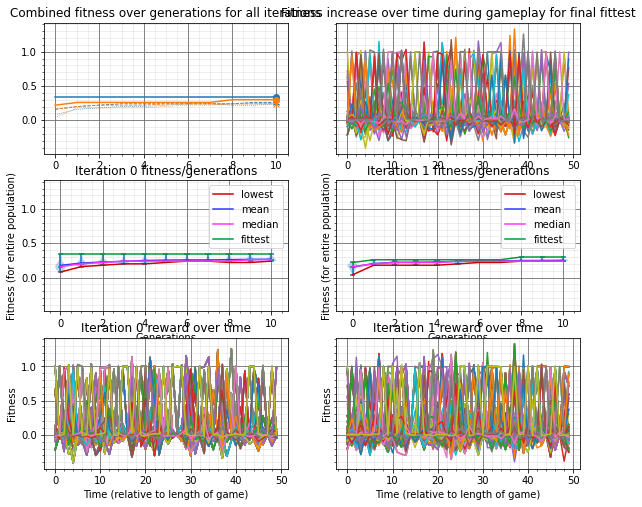

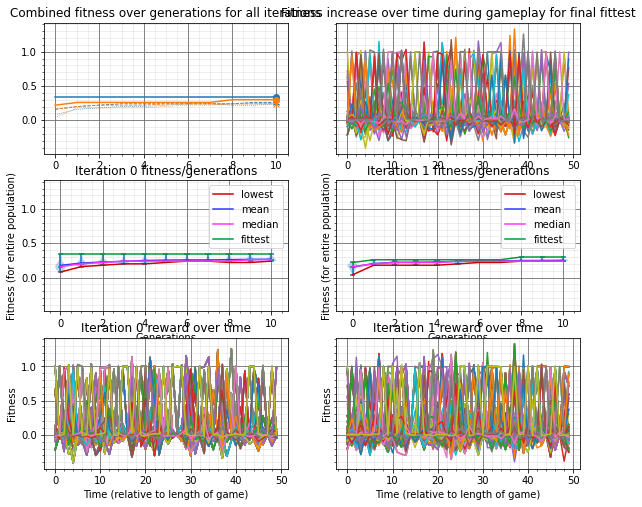

In [11]:
runner.produce_graph(gens)



